In [1]:
import cv2 as cv
import dlib
from imutils import face_utils
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
import os

%matplotlib inline

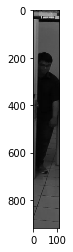

In [2]:
img = cv.imread('../person_data/1_0.png')

gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

# First Framework

1. Detection: Haar Cascade Classifier  
2. Landmark Extraction: DLib (Kazemi & Sullivan Method)  
3. Keyframe Extraction: Using thresholding on the size of the landmark

## Detect Faces

In [3]:
haar_classifier = cv.CascadeClassifier('model_data/haarcascade_frontalface_alt.xml')

In [4]:
def detect_faces(cascade_classifier, gray_img, scale_factor=1.1, min_neighbors=5):
       
    faces = cascade_classifier.detectMultiScale(gray_img, scaleFactor=scale_factor, minNeighbors=min_neighbors)
    
    for (x, y, w, h) in faces:
        cv.rectangle(gray_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    return gray_img, faces

In [5]:
img_with_face_bboxes, faces_position = detect_faces(haar_classifier, gray_img)

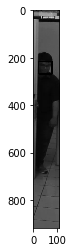

In [6]:
plt.imshow(img_with_face_bboxes, cmap='gray')

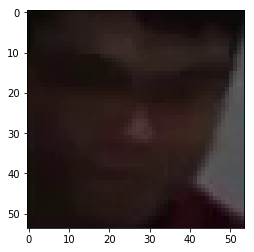

In [7]:
for x, y, w, h in faces_position:
    face_img = img[y:y+h, x:x+w]
    plt.imshow(cv.cvtColor(face_img, cv.COLOR_BGR2RGB))

In [8]:
faces_position

array([[ 23, 215,  54,  54]], dtype=int32)

## Facial Landmark Extraction

For the detail of landmark index for the face regions see following link:
https://www.pyimagesearch.com/2017/04/10/detect-eyes-nose-lips-jaw-dlib-opencv-python/

Caution!!! The image on that link is 1-based index, convert it to 0-based index by subtraction of 1

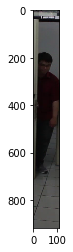

In [9]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [10]:
extractor = dlib.shape_predictor('model_data/shape_predictor_68_face_landmarks.dat')

In [11]:
def facial_landmark_extraction(extractor, gray_img, face_bboxes_position):
    '''
    @brief: The function extract all facial landmark from a frame
    Return: Dictionary of all facial landmark from a frame with key=face_index
    '''
    facial_landmark_list = dict()
    for i, (x, y, w, h) in enumerate(face_bboxes_position):
        rect = dlib.rectangle(x, y, x+w, y+h)
        
        shape = extractor(gray_img, rect)
        shape = face_utils.shape_to_np(shape)
        
        facial_landmark_list[i] = shape
        
    return facial_landmark_list

In [12]:
facials_landmarks_dict = facial_landmark_extraction(extractor, gray_img, faces_position)

In [13]:
# index point for the facial landmark for the jaw (0,16) mean point 0 until 16 is the point of jaw landmark
FACIAL_LANDMARKS_IDXS = dict({
    'jaw': (0, 16),
    'right_eyebrow': (17, 21),
    'left_eyebrow': (22, 26),
    'nose': (27, 35),
    'right_eye': (36, 41),
    'left_eye': (42, 47),
    'mouth': (48, 68)
})

In [14]:
img_with_landmark = img_with_face_bboxes.copy()
for face_idx in facials_landmarks_dict:
    for i, (x, y) in enumerate(facials_landmarks_dict[face_idx]):
        cv.circle(img_with_landmark, (x,y), 1, (0, 255, 0), -1)

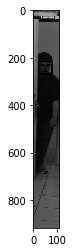

In [15]:
plt.imshow(img_with_landmark, cmap='gray')

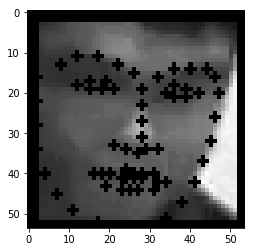

In [16]:
for x, y, w, h in faces_position:
    cropped_img = img_with_landmark[y:y+h, x:x+w]
    plt.imshow(cropped_img, cmap='gray')

## Keyframe Extraction

In [17]:
FACIAL_LANDMARKS_CORNERS_IDXS = {
    'jaw': (0, 16),
    'right_eyebrow': (17, 21),
    'left_eyebrow': (22, 26),
    'nose': (27, 33), # From Top to Bot
    'right_eye': (36, 39), 
    'left_eye': (42, 45),
    'mouth': (48, 54)
}

In [18]:
def landmark_size_extraction(facial_landmarks_dict):
    for face_idx in facial_landmarks_dict:
        landmark = facial_landmarks_dict[face_idx] 
        jaw_idx_corner1, jaw_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['jaw']
        jaw_size = distance.euclidean(landmark[jaw_idx_corner1], landmark[jaw_idx_corner2])
        
        right_eyebrow_idx_corner1, right_eyebrow_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['right_eyebrow']
        right_eyebrow_size = distance.euclidean(landmark[right_eyebrow_idx_corner1], landmark[right_eyebrow_idx_corner2])
        
        left_eyebrow_idx_corner1, left_eyebrow_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['left_eyebrow']
        left_eyebrow_size = distance.euclidean(landmark[left_eyebrow_idx_corner1], landmark[left_eyebrow_idx_corner2])
        
        nose_idx_corner1, nose_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['nose']
        nose_size = distance.euclidean(landmark[nose_idx_corner1], landmark[nose_idx_corner2])
        
        right_eye_idx_corner1, right_eye_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['right_eye']
        right_eye_size = distance.euclidean(landmark[right_eye_idx_corner1], landmark[right_eye_idx_corner2])
        
        left_eye_idx_corner1, left_eye_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['left_eye']
        left_eye_size = distance.euclidean(landmark[left_eye_idx_corner1], landmark[left_eye_idx_corner2])
        
        mouth_idx_corner1, mouth_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['mouth']
        mouth_size = distance.euclidean(landmark[mouth_idx_corner1], landmark[mouth_idx_corner2])

        return (jaw_size, right_eyebrow_size, left_eyebrow_size, nose_size, right_eye_size, left_eye_size, mouth_size)

In [19]:
landmark_size_extraction({})

## One Function to Extract the Keyframe

In [20]:
haar_classifier = cv.CascadeClassifier('model_data/haarcascade_frontalface_alt.xml')
extractor = dlib.shape_predictor('model_data/shape_predictor_68_face_landmarks.dat')


In [21]:
def detect_faces_v2(cascade_classifier, gray_img, scale_factor=1.1, min_neighbors=5):
       
    faces = cascade_classifier.detectMultiScale(gray_img, scaleFactor=scale_factor, minNeighbors=min_neighbors)
    
    return faces

In [22]:
def facial_landmark_extraction_v2(extractor, gray_img, face_bboxes_position):
    '''
    @brief: The function extract all facial landmark from a gray face image
    Return: Dictionary of all facial landmark from a frame with key=face_index
    '''
    x, y, w, h = face_bboxes_position
    
    rect = dlib.rectangle(x, y, x+w, y+h)
        
    shape = extractor(gray_img, rect)
    shape = face_utils.shape_to_np(shape)
        
    facial_landmarks_position = shape
        
    return facial_landmarks_position

In [23]:
def landmark_size_extraction_v2(facial_landmarks_position):
    landmark = facial_landmarks_position 
    jaw_idx_corner1, jaw_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['jaw']
    jaw_size = distance.euclidean(landmark[jaw_idx_corner1], landmark[jaw_idx_corner2])

    right_eyebrow_idx_corner1, right_eyebrow_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['right_eyebrow']
    right_eyebrow_size = distance.euclidean(landmark[right_eyebrow_idx_corner1], landmark[right_eyebrow_idx_corner2])

    left_eyebrow_idx_corner1, left_eyebrow_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['left_eyebrow']
    left_eyebrow_size = distance.euclidean(landmark[left_eyebrow_idx_corner1], landmark[left_eyebrow_idx_corner2])

    nose_idx_corner1, nose_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['nose']
    nose_size = distance.euclidean(landmark[nose_idx_corner1], landmark[nose_idx_corner2])

    right_eye_idx_corner1, right_eye_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['right_eye']
    right_eye_size = distance.euclidean(landmark[right_eye_idx_corner1], landmark[right_eye_idx_corner2])

    left_eye_idx_corner1, left_eye_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['left_eye']
    left_eye_size = distance.euclidean(landmark[left_eye_idx_corner1], landmark[left_eye_idx_corner2])

    mouth_idx_corner1, mouth_idx_corner2 = FACIAL_LANDMARKS_CORNERS_IDXS['mouth']
    mouth_size = distance.euclidean(landmark[mouth_idx_corner1], landmark[mouth_idx_corner2])

    return (jaw_size, right_eyebrow_size, left_eyebrow_size, nose_size, right_eye_size, left_eye_size, mouth_size)

In [24]:
def check_person_image_keyframe(filename, face_detection_classifier, facial_landmark_extractor):
#     resized_dimension = (200, 900)
#     gray_img = cv.resize(cv.imread(filename, cv.IMREAD_GRAYSCALE), resized_dimension, cv.INTER_AREA) 
    gray_img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    plt.imshow(gray_img, cmap='gray')
    plt.show()
    
    faces_position = detect_faces_v2(face_detection_classifier, gray_img)
    for x, y, w, h in faces_position:
        face_img = gray_img[y:y+h, x:x+w]
        face_resized_dimension = (60, 60)
        face_img = cv.resize(face_img, face_resized_dimension, cv.INTER_AREA)
        plt.imshow(face_img, cmap='gray')
        plt.show()
        
        facials_landmarks_position = facial_landmark_extraction_v2(extractor, face_img, (0,0,60,60))
        face_img_copy = face_img.copy()
        for (x, y) in facials_landmarks_position:
            cv.circle(face_img_copy, (x,y), 1, (0, 255, 0), -1)
        plt.imshow(face_img_copy, cmap='gray')
        plt.show()
        
        landmark_size = landmark_size_extraction_v2(facials_landmarks_position)
        if landmark_size != None:
            jaw_size, reb_size, leb_size, nose_size, re_size, le_size, mouth_size = landmark_size
            print(jaw_size, reb_size, leb_size, nose_size, re_size, le_size, mouth_size)
        else:
            print('No Face Found')
#   facials_landmarks_dict = facial_landmark_extraction(extractor, gray_img, faces_position)
    
#     img_with_landmark = img_with_face_bboxes.copy()
#     for face_idx in facials_landmarks_dict:
#         for i, (x, y) in enumerate(facials_landmarks_dict[face_idx]):
#             cv.circle(img_with_landmark, (x,y), 1, (0, 255, 0), -1)
            
#     for x, y, w, h in faces_position:
#         cropped_img = img_with_landmark[y:y+h, x:x+w]
#         plt.imshow(cropped_img, cmap='gray')
#         plt.show()
        
#     landmarks_size = landmark_size_extraction(facials_landmarks_dict)
#     if landmarks_size != None:
#         jaw_size, reb_size, leb_size, nose_size, re_size, le_size, mouth_size = landmarks_size
#         print(jaw_size, reb_size, leb_size, nose_size, re_size, le_size, mouth_size)
#     else:
#         print('No Facial Landmark Found')

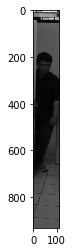

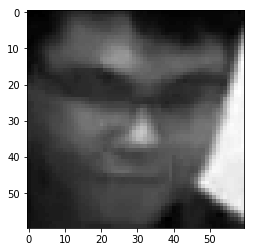

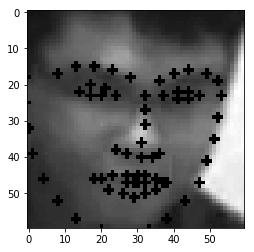

54.230987451824994 20.024984394500787 16.0 17.029386365926403 10.04987562112089 10.0 20.024984394500787


In [25]:
check_person_image_keyframe('../person_data/1_1.png', haar_classifier, extractor)

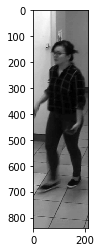

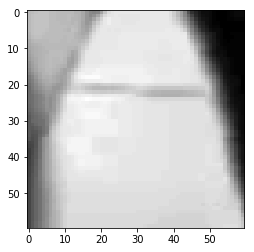

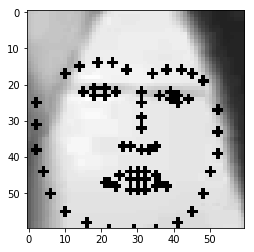

50.039984012787215 17.029386365926403 14.142135623730951 16.0 9.0 8.06225774829855 17.029386365926403


In [26]:
check_person_image_keyframe('../person_data/2_40.png', haar_classifier, extractor)

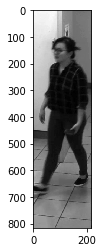

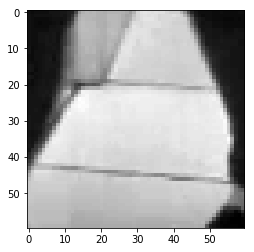

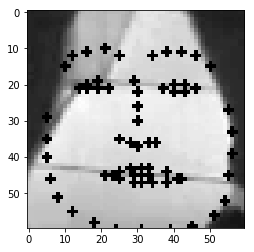

50.039984012787215 15.297058540778355 16.278820596099706 18.027756377319946 8.0 9.0 21.02379604162864


In [27]:
check_person_image_keyframe('../person_data/2_42.png', haar_classifier, extractor)

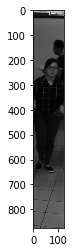

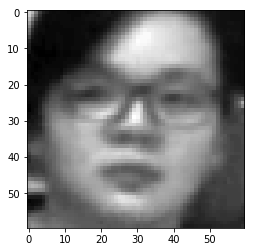

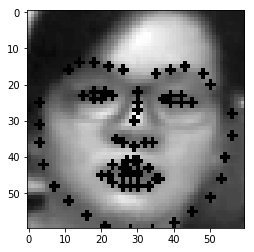

53.08483775994799 15.0 15.297058540778355 15.033296378372908 8.0 8.06225774829855 16.0312195418814


In [28]:
check_person_image_keyframe('../person_data/2_6.png', haar_classifier, extractor)

## Batch Function to Generate All Keyframe from All Image of a Person

In [29]:
def generate_keyframe_from_frames(input_path_list, output_dir_path, face_detection_classifier, facial_landmark_extractor):
    for file_path in input_path_list:
        print(file_path)
        check_person_image_keyframe(file_path, face_detection_classifier, facial_landmark_extractor)

In [30]:
input_path_list = os.listdir('../person_data/')
input_path_list = ['../person_data/' + element for element in input_path_list]
input_path_list = [element for element in input_path_list if '/2_' in element]
input_path_list = sorted(input_path_list)
input_path_list[0:2]

['../person_data/2_0.png', '../person_data/2_1.png']

../person_data/2_0.png


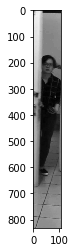

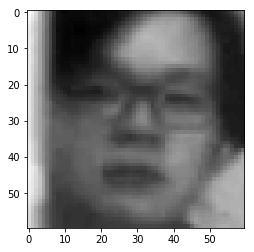

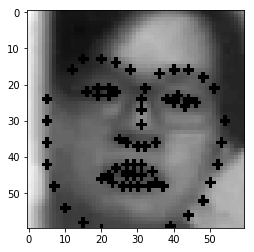

49.36598018878993 16.0 15.524174696260024 16.1245154965971 8.0 8.06225774829855 17.11724276862369
../person_data/2_1.png


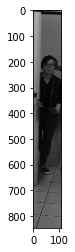

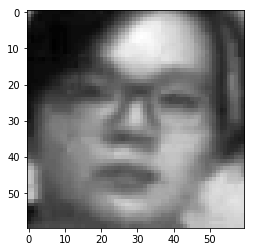

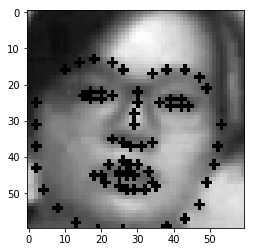

51.35172830587107 16.0 15.524174696260024 15.132745950421556 8.0 8.06225774829855 17.26267650163207
../person_data/2_10.png


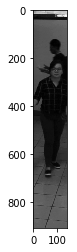

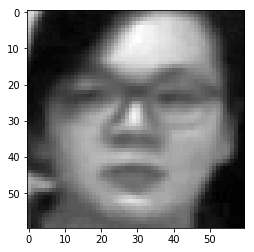

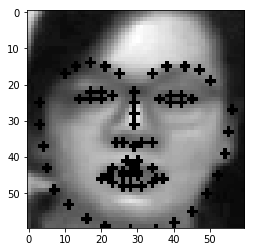

53.03772242470448 15.0 16.1245154965971 15.0 9.055385138137417 9.0 17.0
../person_data/2_11.png


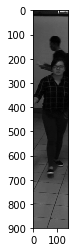

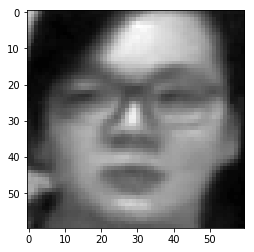

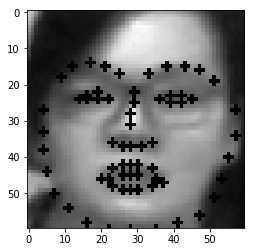

53.0 16.0312195418814 18.110770276274835 15.033296378372908 8.0 9.0 17.029386365926403
../person_data/2_12.png


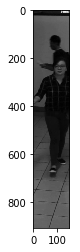

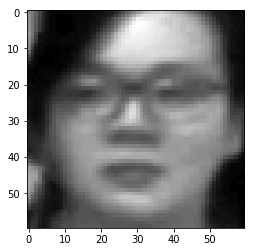

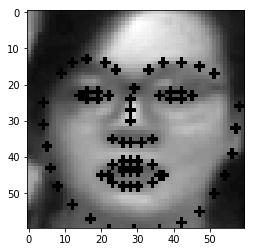

54.00925846556311 15.033296378372908 18.027756377319946 15.033296378372908 8.0 9.0 17.0
../person_data/2_13.png


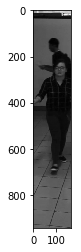

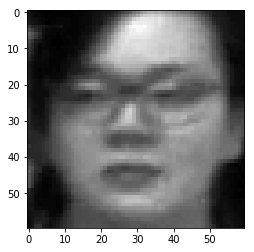

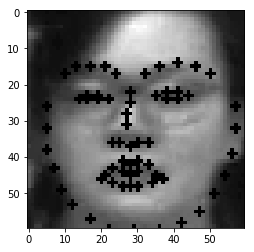

52.0 14.0 18.0 15.0 8.0 9.0 17.0
../person_data/2_14.png


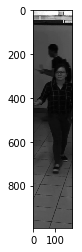

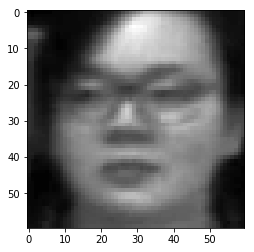

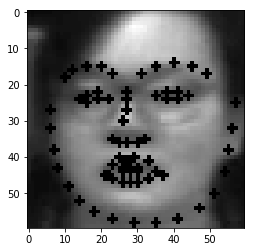

51.03920062069938 13.038404810405298 18.0 14.0 8.0 9.0 16.0
../person_data/2_15.png


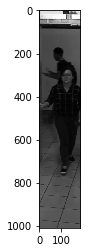

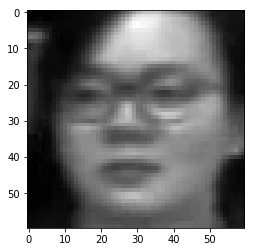

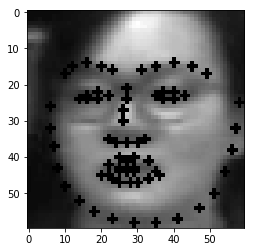

52.009614495783374 13.038404810405298 18.027756377319946 15.0 8.06225774829855 8.0 16.0
../person_data/2_16.png


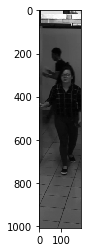

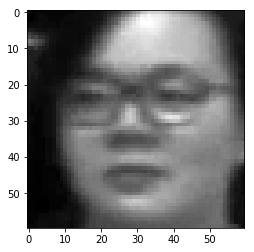

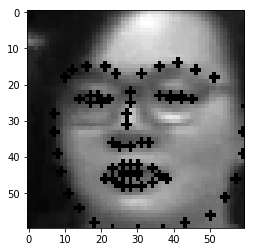

53.03772242470448 14.035668847618199 20.024984394500787 15.0 8.0 9.055385138137417 17.0
../person_data/2_17.png


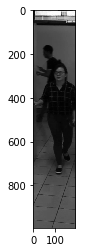

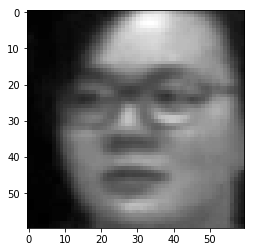

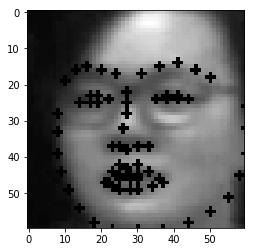

52.03844732503075 14.142135623730951 19.026297590440446 16.0 8.06225774829855 9.0 16.0
../person_data/2_18.png


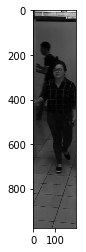

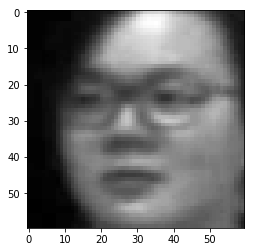

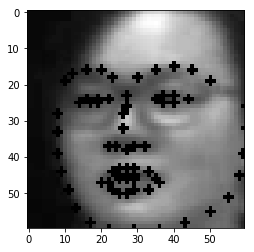

52.03844732503075 13.038404810405298 20.024984394500787 15.0 8.06225774829855 9.0 16.0
../person_data/2_19.png


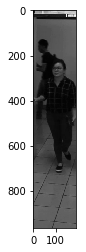

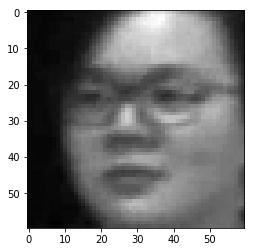

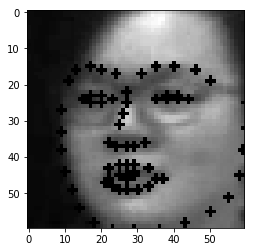

51.03920062069938 13.152946437965905 19.1049731745428 15.0 8.0 9.0 16.0312195418814
../person_data/2_2.png


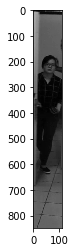

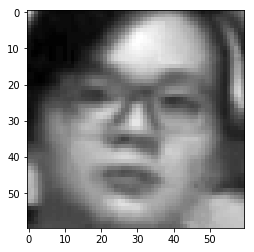

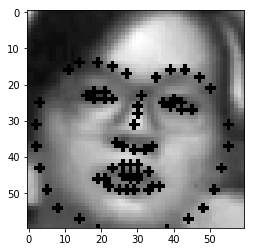

52.3450093132096 16.0312195418814 15.297058540778355 15.132745950421556 7.0710678118654755 8.246211251235321 17.11724276862369
../person_data/2_20.png


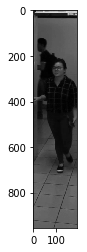

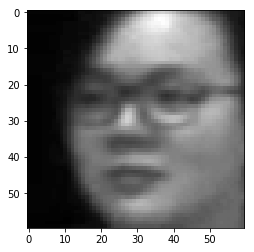

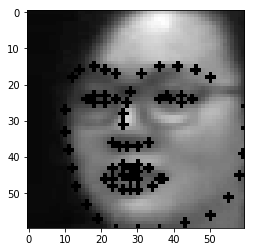

50.00999900019995 12.041594578792296 19.026297590440446 15.033296378372908 8.0 9.0 16.0
../person_data/2_21.png


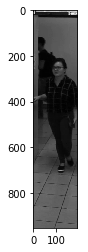

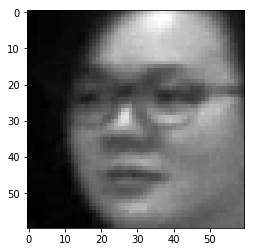

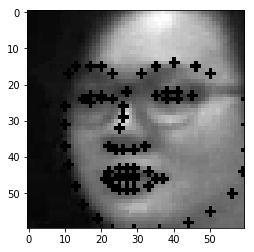

50.039984012787215 12.0 19.0 16.0312195418814 8.0 10.0 16.0
../person_data/2_22.png


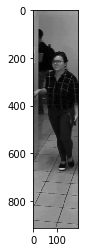

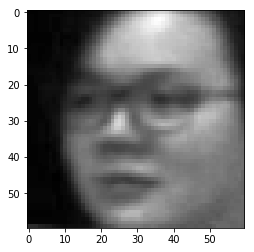

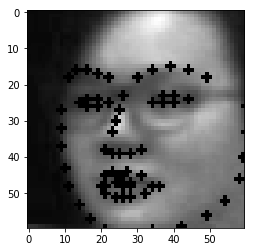

51.0098029794274 11.0 19.0 16.0312195418814 8.0 10.04987562112089 16.0
../person_data/2_23.png


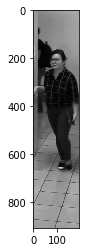

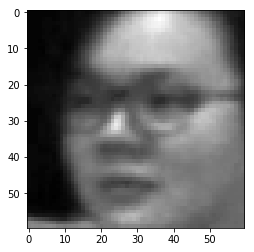

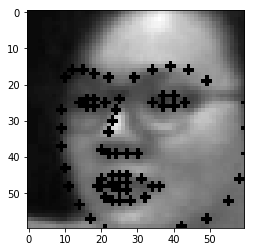

51.03920062069938 12.0 20.024984394500787 15.033296378372908 7.0 9.0 17.0
../person_data/2_24.png


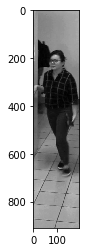

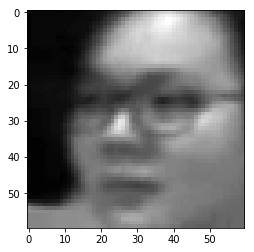

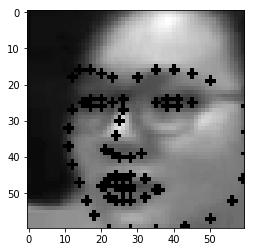

48.010415536631214 11.0 20.024984394500787 16.0312195418814 8.0 10.0 16.0312195418814
../person_data/2_25.png


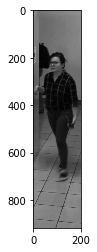

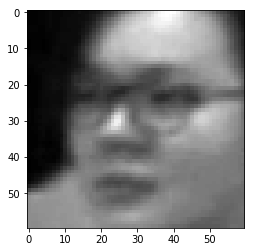

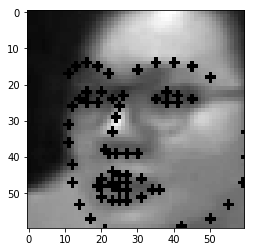

49.0 11.0 20.09975124224178 16.1245154965971 9.0 10.0 17.029386365926403
../person_data/2_26.png


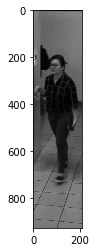

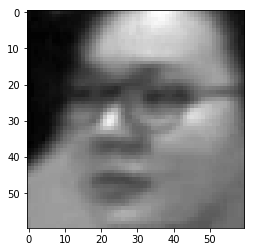

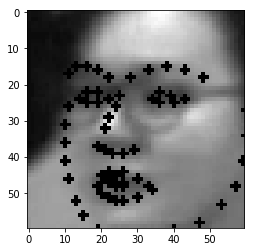

49.01020301937138 11.045361017187261 20.0 16.1245154965971 8.0 9.0 15.033296378372908
../person_data/2_27.png


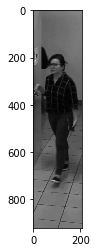

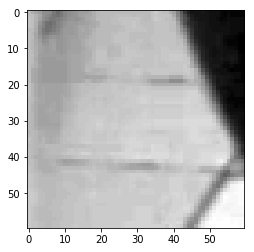

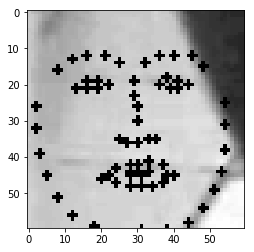

52.009614495783374 17.11724276862369 16.0312195418814 17.029386365926403 9.055385138137417 8.0 20.024984394500787


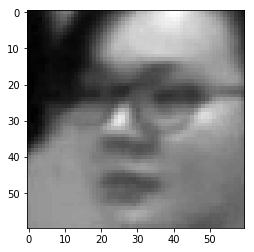

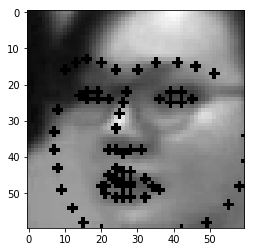

53.009433122794285 14.0 21.02379604162864 17.029386365926403 8.06225774829855 9.0 16.0312195418814
../person_data/2_28.png


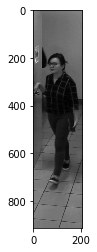

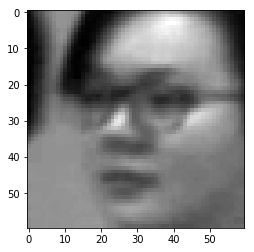

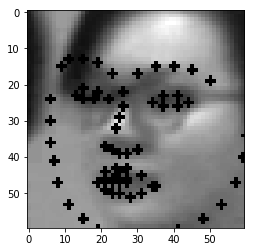

55.08175741568164 14.142135623730951 20.09975124224178 17.029386365926403 9.055385138137417 10.0 16.0312195418814
../person_data/2_29.png


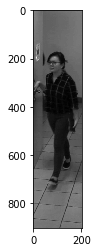

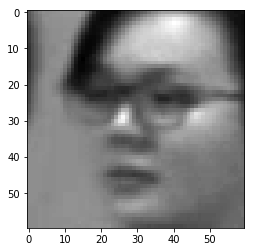

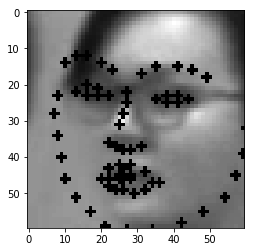

53.03772242470448 13.152946437965905 18.027756377319946 16.0312195418814 9.055385138137417 9.0 16.0312195418814
../person_data/2_3.png


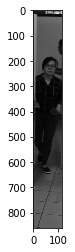

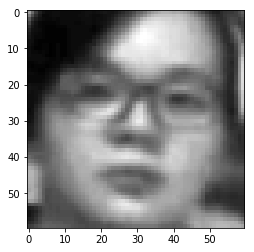

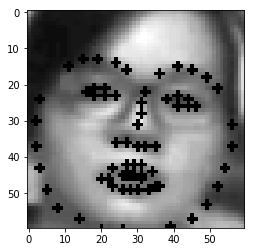

53.46026561849464 16.0312195418814 16.492422502470642 15.132745950421556 8.06225774829855 8.246211251235321 16.1245154965971
../person_data/2_30.png


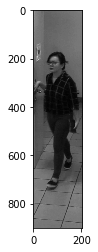

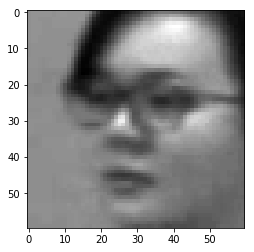

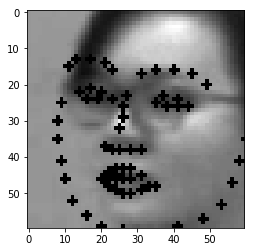

52.08646657242167 12.041594578792296 18.24828759089466 15.132745950421556 9.219544457292887 9.055385138137417 15.132745950421556
../person_data/2_31.png


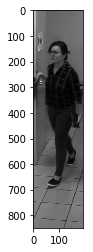

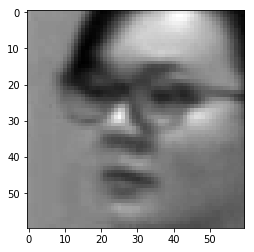

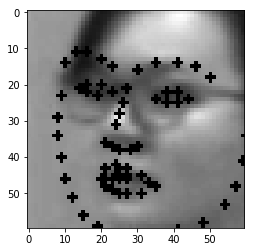

52.23983154643591 13.038404810405298 20.09975124224178 17.11724276862369 9.055385138137417 9.0 15.132745950421556
../person_data/2_32.png


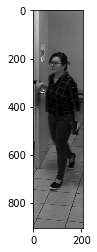

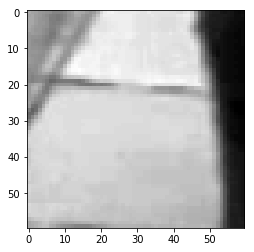

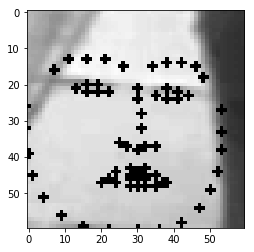

54.00925846556311 19.026297590440446 14.317821063276353 17.0 9.055385138137417 9.0 18.0


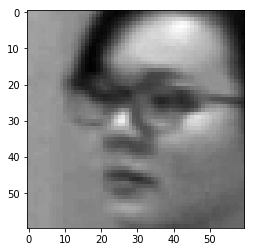

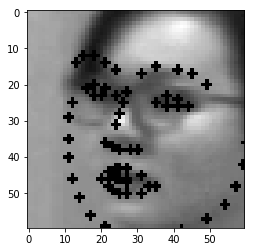

49.25444142409901 11.180339887498949 18.24828759089466 16.1245154965971 8.246211251235321 9.055385138137417 15.132745950421556
../person_data/2_33.png


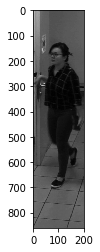

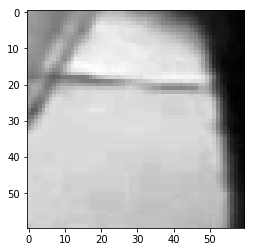

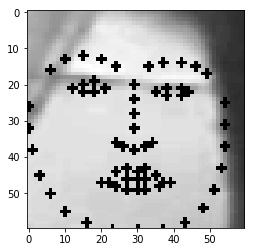

54.00925846556311 18.027756377319946 16.1245154965971 18.0 9.0 9.0 19.0


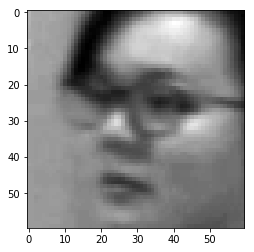

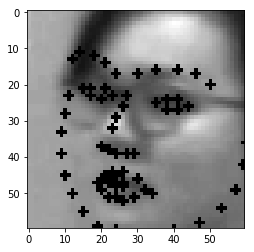

50.35871324805669 12.649110640673518 20.223748416156685 16.278820596099706 8.246211251235321 9.055385138137417 15.297058540778355
../person_data/2_34.png


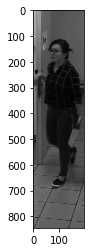

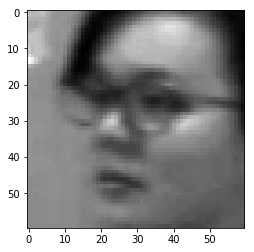

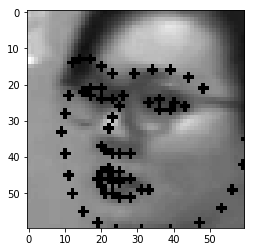

50.35871324805669 11.40175425099138 19.4164878389476 16.278820596099706 8.246211251235321 10.04987562112089 14.317821063276353
../person_data/2_35.png


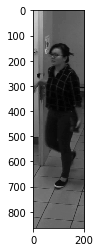

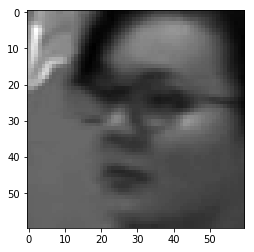

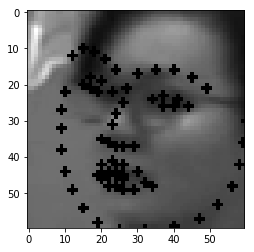

50.635955604688654 12.649110640673518 19.4164878389476 16.278820596099706 8.246211251235321 10.198039027185569 15.297058540778355
../person_data/2_36.png


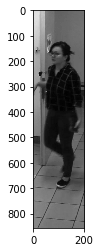

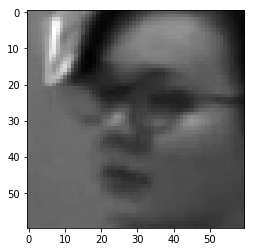

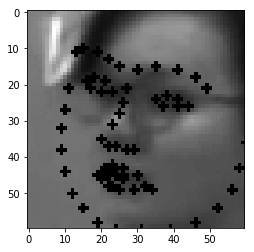

50.80354318352215 12.649110640673518 19.6468827043885 16.278820596099706 7.615773105863909 9.219544457292887 15.524174696260024
../person_data/2_37.png


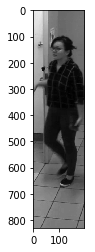

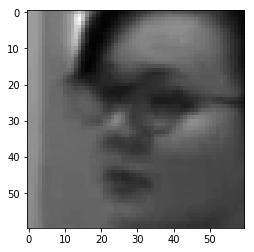

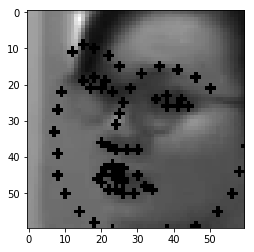

52.773099207835045 13.601470508735444 19.4164878389476 17.46424919657298 8.54400374531753 9.219544457292887 15.297058540778355
../person_data/2_38.png


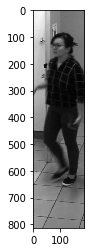

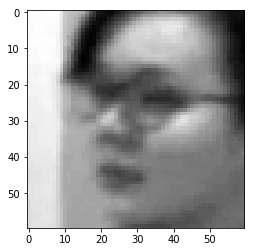

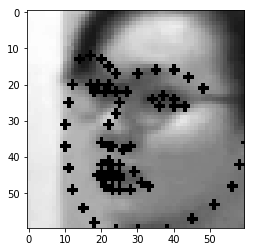

49.8196748283246 10.770329614269007 18.439088914585774 15.524174696260024 7.280109889280518 9.219544457292887 14.317821063276353
../person_data/2_39.png


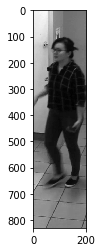

../person_data/2_4.png


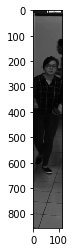

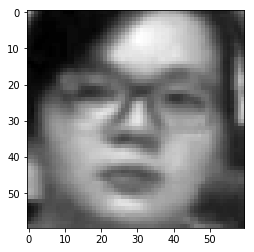

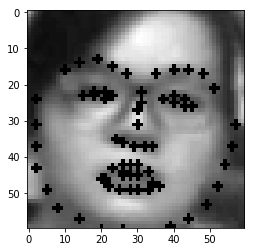

55.44366510251645 17.029386365926403 16.492422502470642 15.132745950421556 8.0 8.246211251235321 16.1245154965971
../person_data/2_40.png


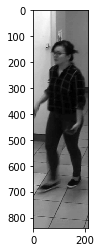

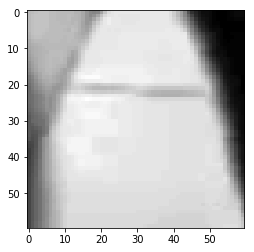

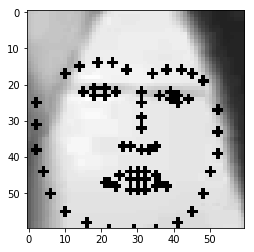

50.039984012787215 17.029386365926403 14.142135623730951 16.0 9.0 8.06225774829855 17.029386365926403
../person_data/2_41.png


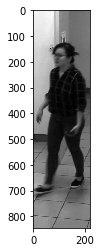

../person_data/2_42.png


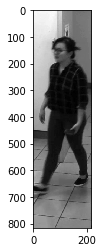

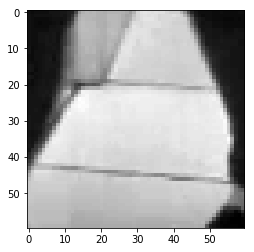

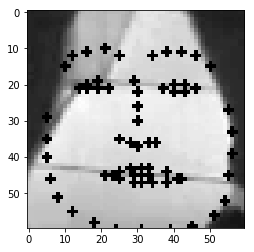

50.039984012787215 15.297058540778355 16.278820596099706 18.027756377319946 8.0 9.0 21.02379604162864
../person_data/2_43.png


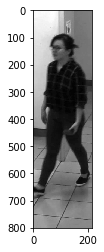

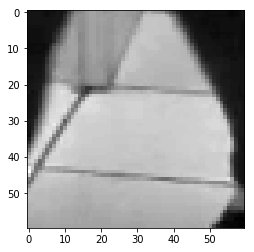

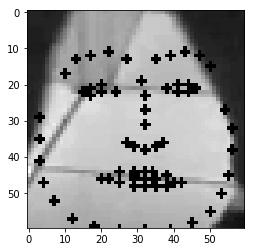

51.03920062069938 17.46424919657298 15.132745950421556 19.026297590440446 9.0 8.0 22.02271554554524
../person_data/2_44.png


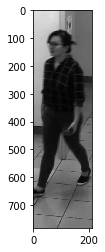

../person_data/2_45.png


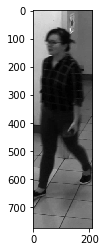

../person_data/2_46.png


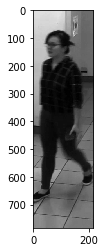

../person_data/2_47.png


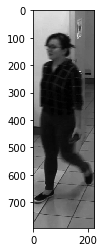

../person_data/2_48.png


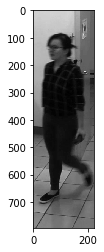

../person_data/2_49.png


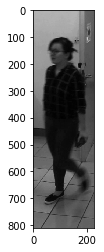

../person_data/2_5.png


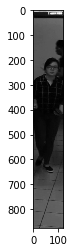

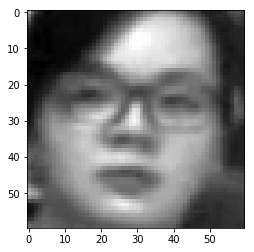

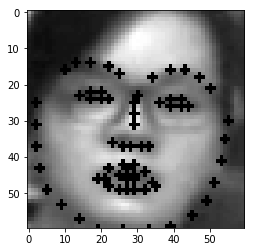

53.23532661682466 15.033296378372908 16.278820596099706 14.142135623730951 8.06225774829855 8.06225774829855 16.1245154965971
../person_data/2_50.png


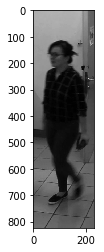

../person_data/2_51.png


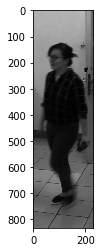

../person_data/2_52.png


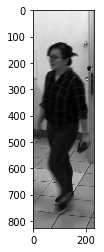

../person_data/2_53.png


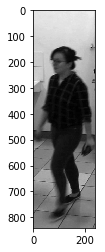

../person_data/2_54.png


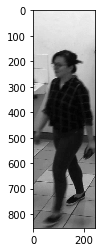

../person_data/2_55.png


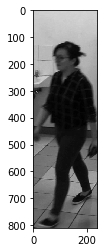

../person_data/2_56.png


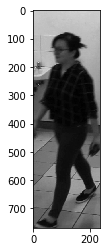

../person_data/2_57.png


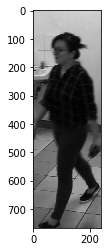

../person_data/2_58.png


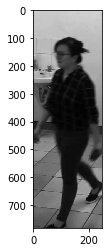

../person_data/2_59.png


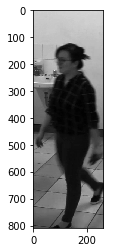

../person_data/2_6.png


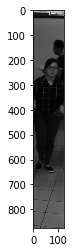

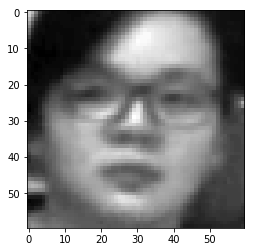

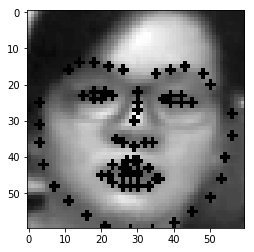

53.08483775994799 15.0 15.297058540778355 15.033296378372908 8.0 8.06225774829855 16.0312195418814
../person_data/2_60.png


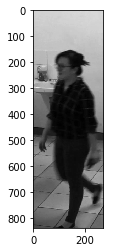

../person_data/2_61.png


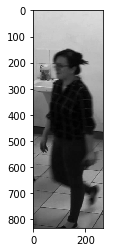

../person_data/2_62.png


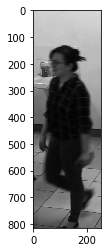

../person_data/2_63.png


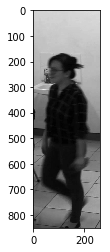

../person_data/2_64.png


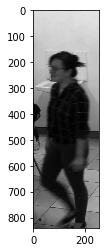

../person_data/2_65.png


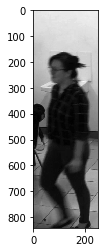

../person_data/2_66.png


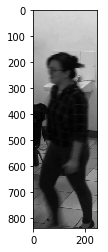

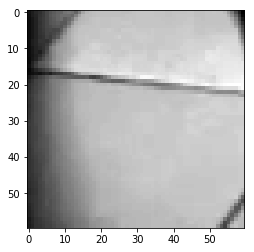

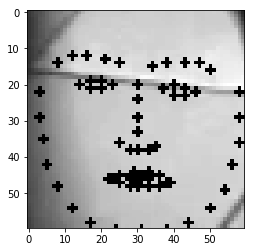

55.0 17.0 16.0312195418814 18.0 9.0 9.055385138137417 17.029386365926403
../person_data/2_67.png


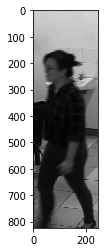

../person_data/2_68.png


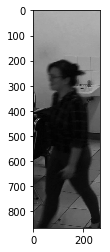

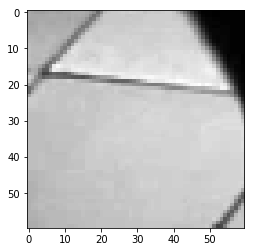

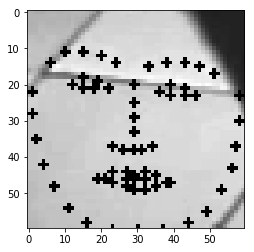

57.0087712549569 18.0 18.110770276274835 18.0 10.04987562112089 10.04987562112089 20.024984394500787
../person_data/2_69.png


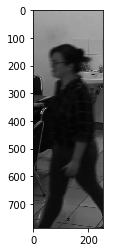

../person_data/2_7.png


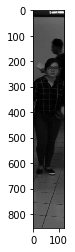

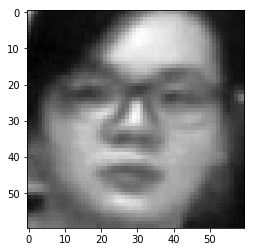

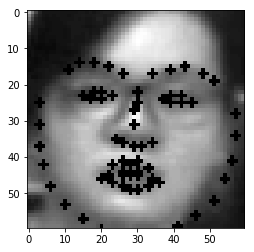

54.08326913195984 15.033296378372908 17.11724276862369 15.033296378372908 8.0 8.06225774829855 16.0312195418814
../person_data/2_70.png


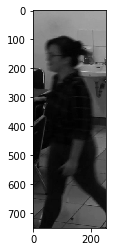

../person_data/2_71.png


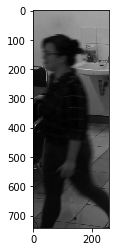

../person_data/2_72.png


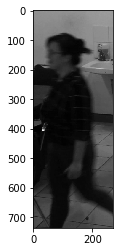

../person_data/2_73.png


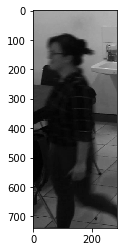

../person_data/2_74.png


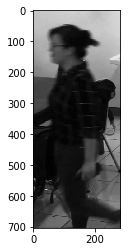

../person_data/2_75.png


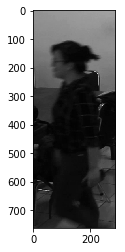

../person_data/2_76.png


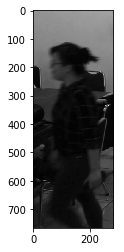

../person_data/2_77.png


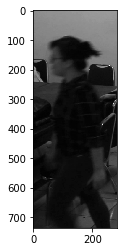

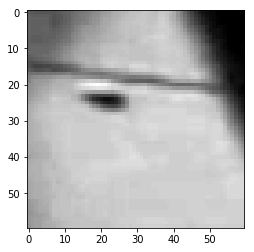

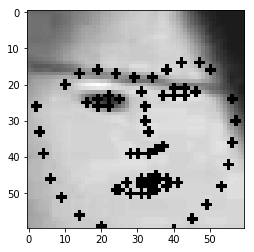

54.037024344425184 19.1049731745428 16.1245154965971 17.11724276862369 9.055385138137417 9.055385138137417 17.11724276862369
../person_data/2_78.png


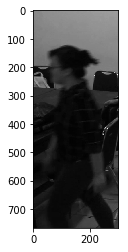

../person_data/2_79.png


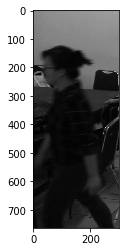

../person_data/2_8.png


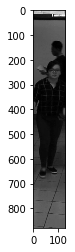

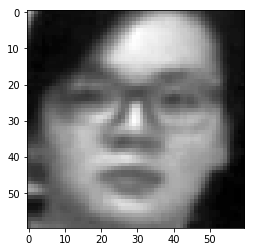

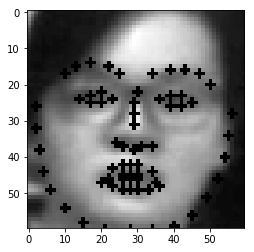

54.037024344425184 15.0 16.278820596099706 16.0312195418814 9.0 9.055385138137417 16.0312195418814
../person_data/2_80.png


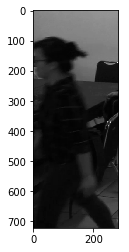

../person_data/2_81.png


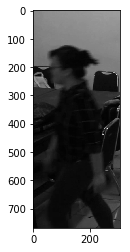

../person_data/2_82.png


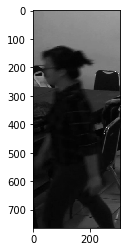

../person_data/2_83.png


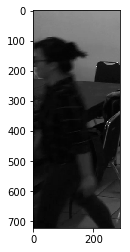

../person_data/2_9.png


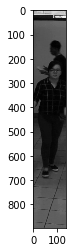

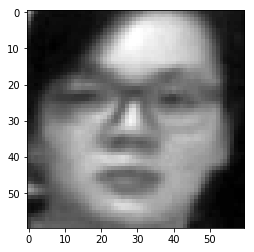

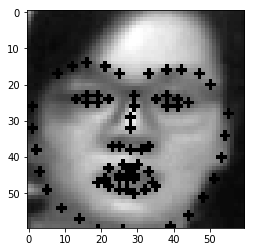

54.037024344425184 17.0 17.26267650163207 15.033296378372908 9.0 9.055385138137417 16.0312195418814


In [31]:
generate_keyframe_from_frames(input_path_list, 'hehe', haar_classifier, extractor)

In [32]:
input_path_list = os.listdir('../person_data/')
input_path_list = ['../person_data/' + element for element in input_path_list]
input_path_list = [element for element in input_path_list if '/12_' in element]
input_path_list = sorted(input_path_list)
input_path_list[0:2]

['../person_data/12_0.png', '../person_data/12_1.png']

../person_data/12_0.png


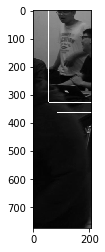

../person_data/12_1.png


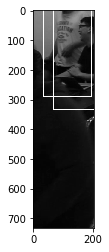

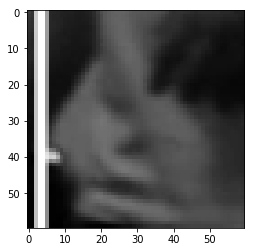

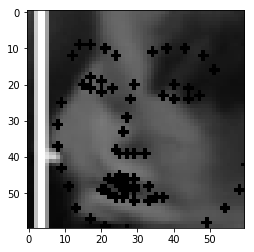

52.08646657242167 12.0 17.72004514666935 19.1049731745428 8.06225774829855 10.0 17.11724276862369
../person_data/12_10.png


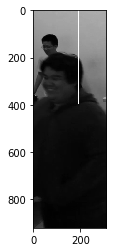

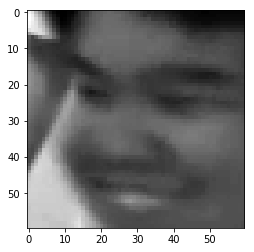

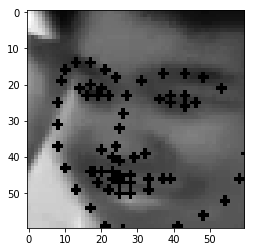

53.23532661682466 14.142135623730951 22.090722034374522 18.110770276274835 8.246211251235321 10.04987562112089 22.090722034374522
../person_data/12_100.png


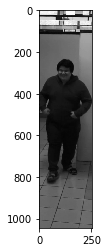

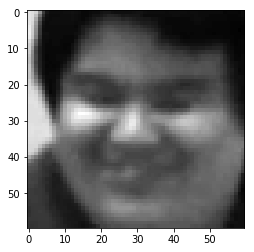

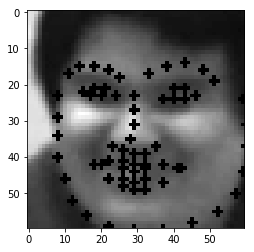

51.0098029794274 14.035668847618199 18.110770276274835 16.0 9.055385138137417 9.055385138137417 24.020824298928627
../person_data/12_101.png


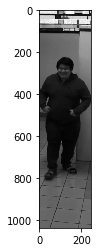

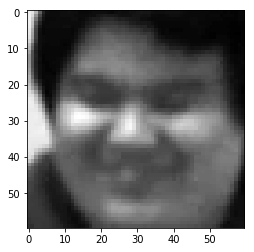

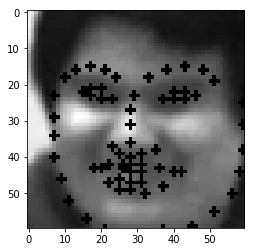

52.03844732503075 14.0 18.027756377319946 17.029386365926403 8.246211251235321 9.055385138137417 24.020824298928627
../person_data/12_102.png


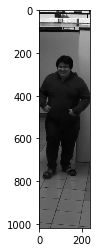

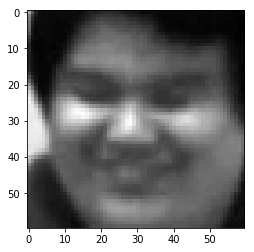

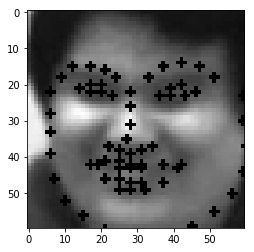

53.009433122794285 15.0 18.0 17.0 9.219544457292887 10.04987562112089 25.0
../person_data/12_103.png


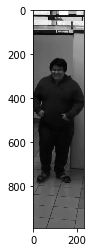

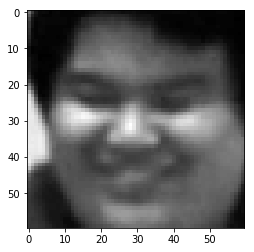

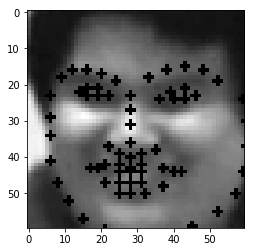

53.009433122794285 15.033296378372908 19.026297590440446 17.0 8.06225774829855 10.04987562112089 25.019992006393608
../person_data/12_104.png


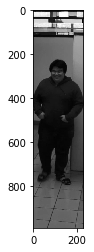

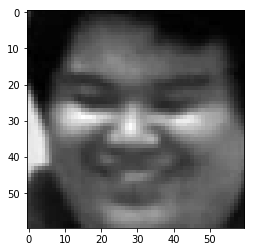

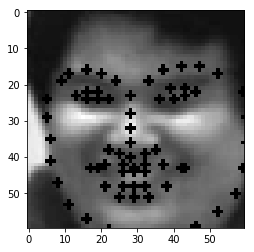

54.037024344425184 15.0 19.1049731745428 17.0 9.055385138137417 10.198039027185569 26.0
../person_data/12_105.png


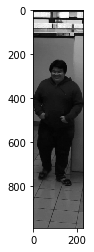

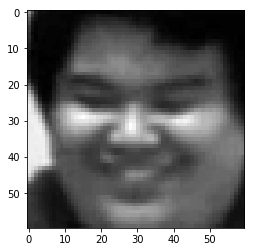

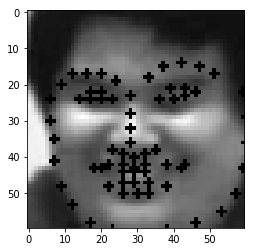

53.03772242470448 15.033296378372908 18.027756377319946 17.029386365926403 9.0 10.198039027185569 25.019992006393608
../person_data/12_106.png


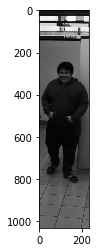

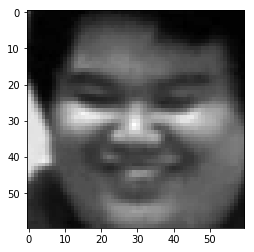

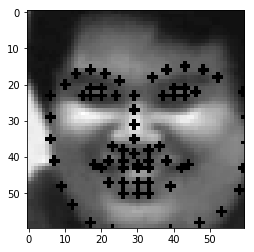

53.009433122794285 15.033296378372908 18.0 16.0 9.0 9.055385138137417 26.0
../person_data/12_107.png


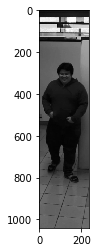

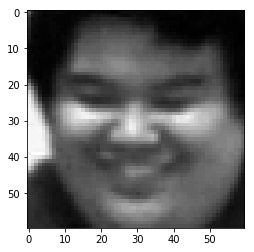

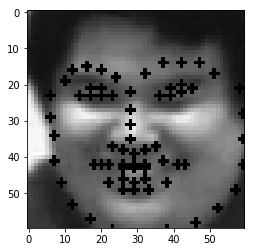

52.03844732503075 14.035668847618199 19.0 17.029386365926403 9.0 9.219544457292887 25.0
../person_data/12_108.png


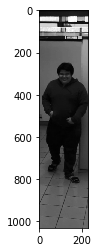

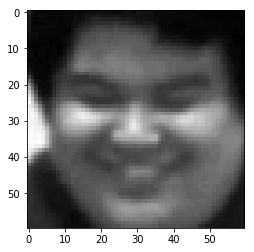

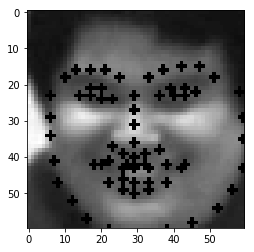

52.009614495783374 15.0 18.0 17.0 9.055385138137417 10.04987562112089 25.0
../person_data/12_109.png


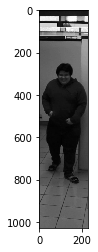

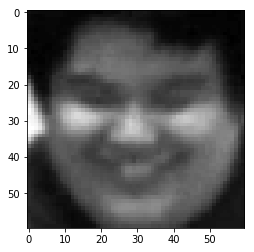

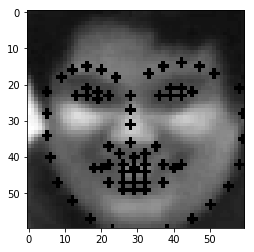

53.009433122794285 15.0 18.0 17.029386365926403 9.0 9.055385138137417 24.020824298928627
../person_data/12_11.png


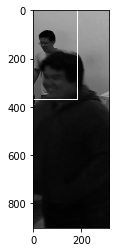

../person_data/12_110.png


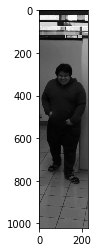

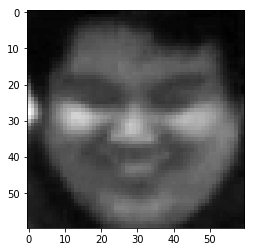

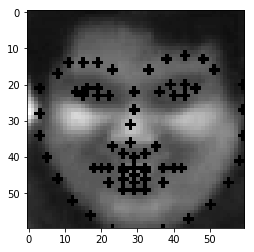

56.00892785976178 15.033296378372908 18.0 18.0 9.055385138137417 10.04987562112089 24.0
../person_data/12_111.png


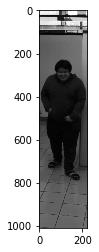

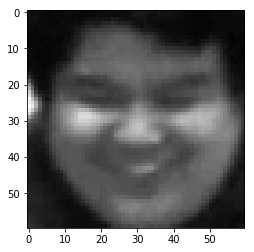

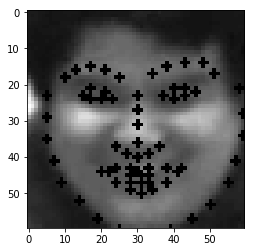

53.03772242470448 15.0 17.0 17.0 8.06225774829855 9.055385138137417 22.02271554554524
../person_data/12_112.png


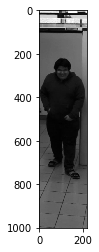

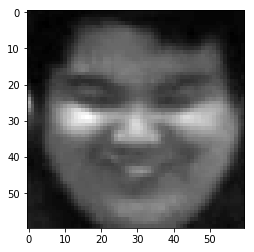

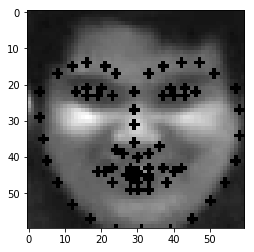

54.00925846556311 16.0 18.0 18.027756377319946 10.04987562112089 9.055385138137417 23.021728866442675
../person_data/12_113.png


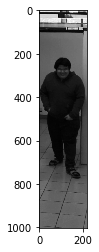

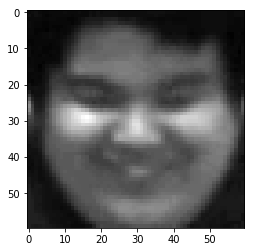

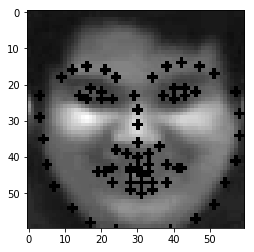

54.00925846556311 15.0 17.029386365926403 17.029386365926403 9.055385138137417 9.055385138137417 23.021728866442675
../person_data/12_114.png


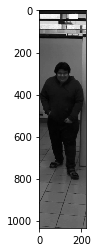

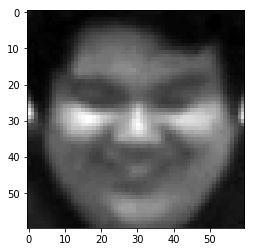

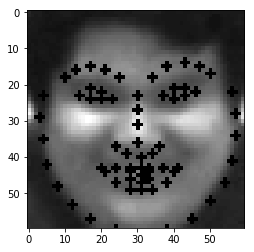

52.009614495783374 15.0 16.0312195418814 17.029386365926403 9.055385138137417 9.055385138137417 21.0
../person_data/12_115.png


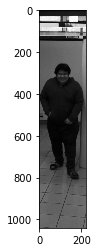

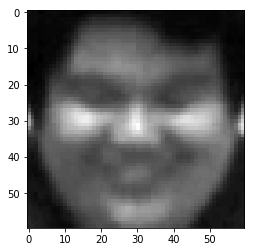

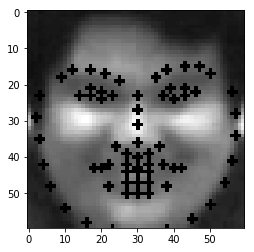

53.009433122794285 16.0312195418814 15.033296378372908 17.0 9.0 9.055385138137417 24.0
../person_data/12_116.png


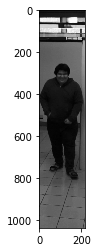

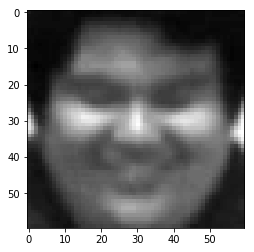

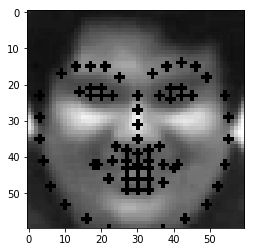

51.0 16.0312195418814 15.033296378372908 16.0 9.055385138137417 9.0 23.0
../person_data/12_117.png


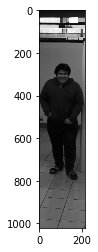

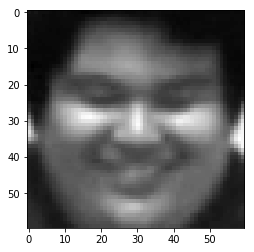

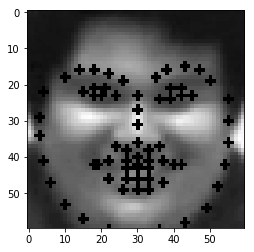

51.03920062069938 16.0312195418814 15.033296378372908 17.0 9.055385138137417 9.055385138137417 24.0
../person_data/12_119.png


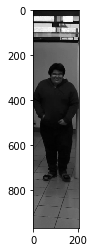

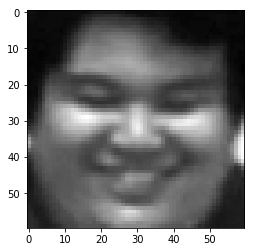

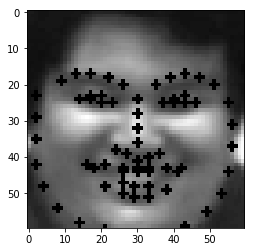

53.03772242470448 17.029386365926403 16.0 17.0 9.055385138137417 9.0 26.019223662515376
../person_data/12_12.png


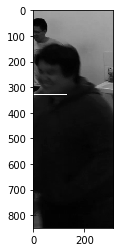

../person_data/12_120.png


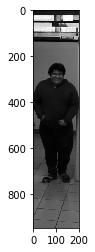

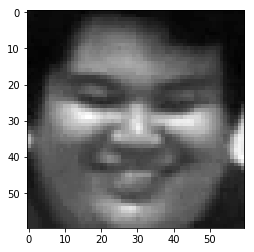

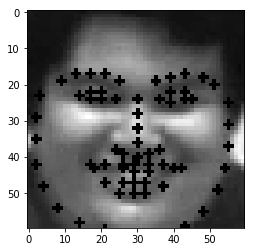

52.03844732503075 16.0 16.0312195418814 16.0 10.04987562112089 9.0 25.019992006393608
../person_data/12_121.png


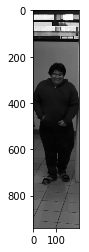

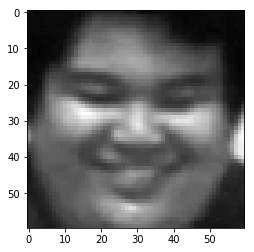

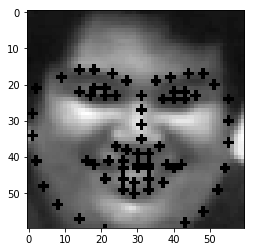

53.08483775994799 18.027756377319946 16.0312195418814 16.0312195418814 10.04987562112089 9.055385138137417 26.019223662515376
../person_data/12_122.png


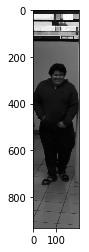

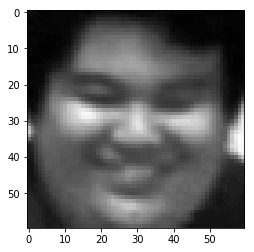

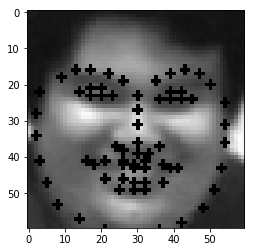

51.088159097779204 17.029386365926403 15.033296378372908 16.0 9.055385138137417 9.0 25.079872407968907
../person_data/12_123.png


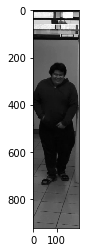

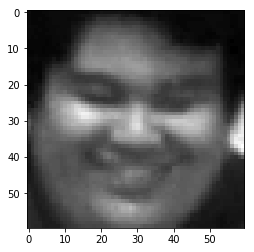

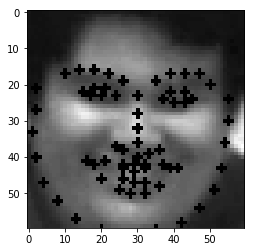

53.08483775994799 16.1245154965971 15.033296378372908 17.0 9.055385138137417 8.0 25.079872407968907
../person_data/12_124.png


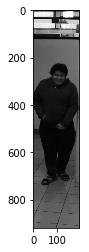

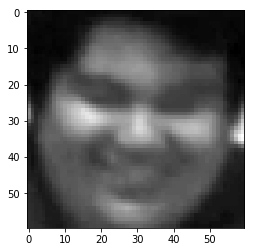

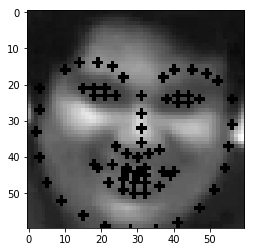

53.08483775994799 16.1245154965971 15.033296378372908 17.029386365926403 9.219544457292887 9.0 22.090722034374522
../person_data/12_125.png


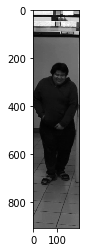

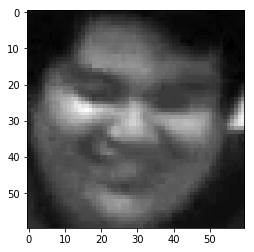

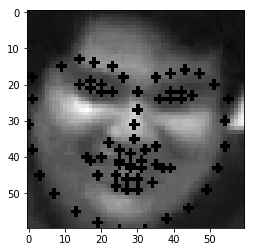

54.3323108288245 17.26267650163207 16.1245154965971 17.11724276862369 9.219544457292887 9.055385138137417 23.194827009486403
../person_data/12_126.png


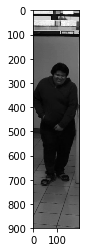

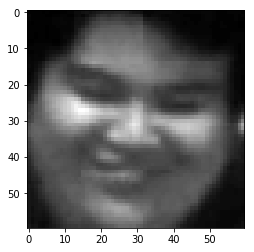

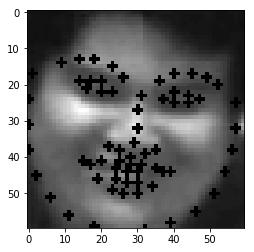

56.568542494923804 17.46424919657298 16.0312195418814 17.26267650163207 9.486832980505138 10.0 24.186773244895647
../person_data/12_127.png


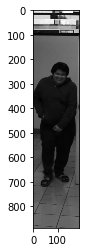

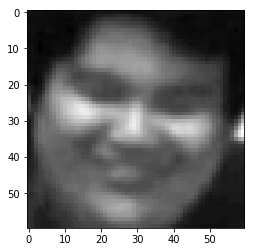

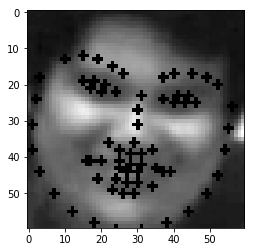

53.600373133029585 16.492422502470642 15.132745950421556 16.278820596099706 9.486832980505138 9.055385138137417 23.194827009486403
../person_data/12_128.png


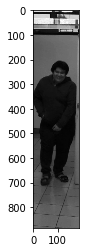

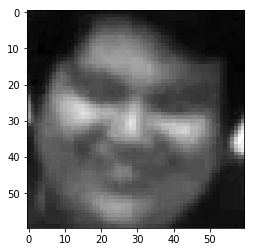

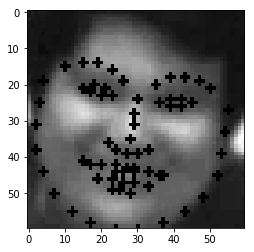

51.62363799656123 16.492422502470642 15.033296378372908 15.297058540778355 8.246211251235321 9.0 22.360679774997898
../person_data/12_129.png


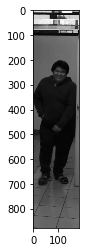

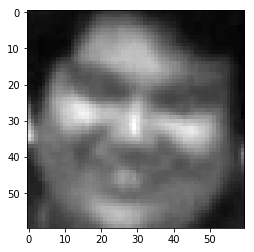

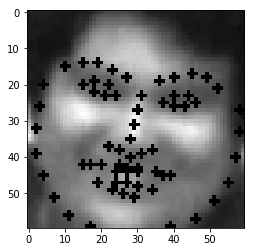

54.45181356024793 17.26267650163207 16.1245154965971 17.26267650163207 9.486832980505138 9.0 24.186773244895647
../person_data/12_13.png


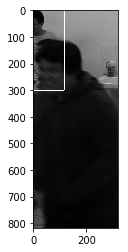

../person_data/12_130.png


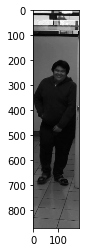

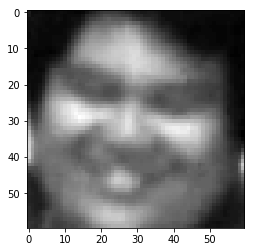

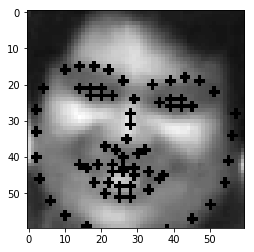

53.46026561849464 16.278820596099706 17.11724276862369 16.278820596099706 9.219544457292887 9.055385138137417 23.194827009486403
../person_data/12_131.png


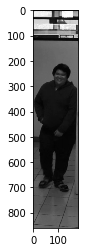

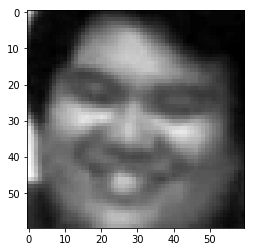

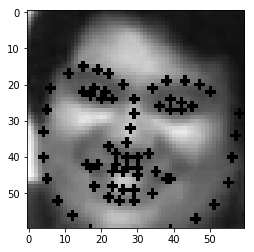

52.46903848937962 15.297058540778355 16.0312195418814 16.1245154965971 8.246211251235321 9.0 23.345235059857504
../person_data/12_132.png


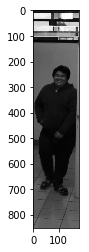

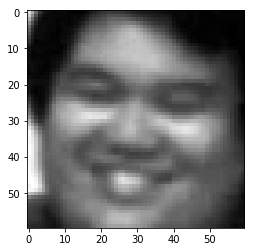

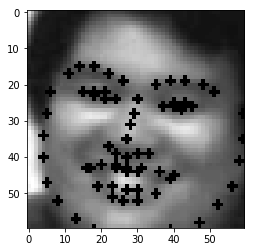

53.33854141237835 15.132745950421556 16.1245154965971 16.278820596099706 9.219544457292887 8.0 24.08318915758459
../person_data/12_133.png


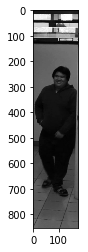

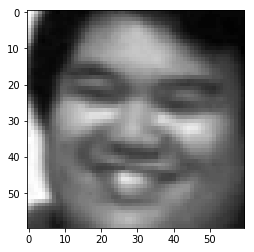

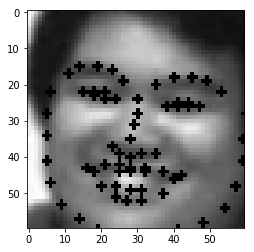

54.3323108288245 15.132745950421556 18.110770276274835 16.1245154965971 9.219544457292887 9.0 26.076809620810597
../person_data/12_134.png


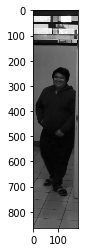

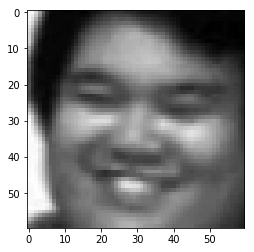

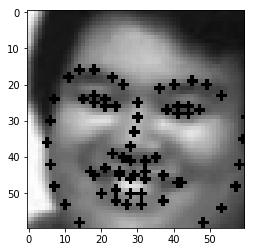

53.23532661682466 15.132745950421556 17.11724276862369 16.1245154965971 9.219544457292887 9.0 25.179356624028344
../person_data/12_135.png


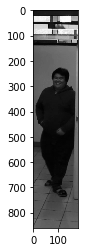

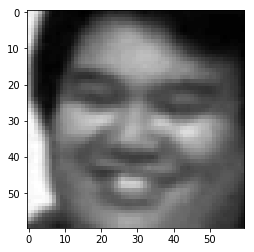

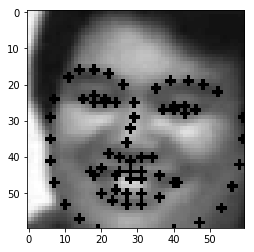

52.23983154643591 15.132745950421556 17.029386365926403 16.0312195418814 9.055385138137417 9.0 24.186773244895647
../person_data/12_136.png


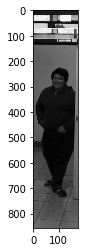

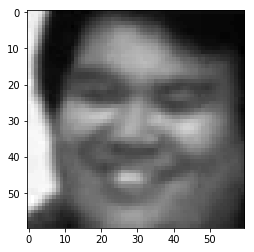

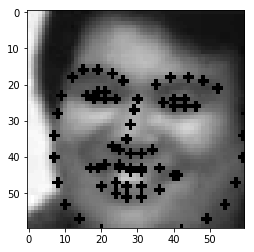

51.24451190127583 14.035668847618199 17.029386365926403 15.132745950421556 8.06225774829855 9.055385138137417 24.08318915758459
../person_data/12_137.png


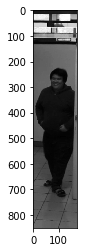

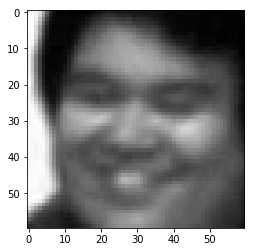

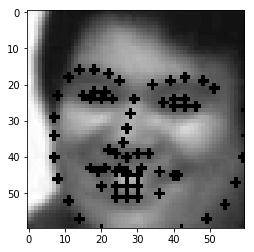

52.15361924162119 14.035668847618199 17.029386365926403 16.1245154965971 8.06225774829855 9.055385138137417 24.08318915758459
../person_data/12_138.png


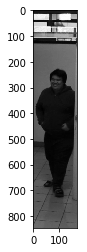

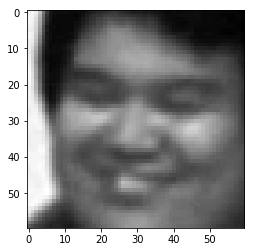

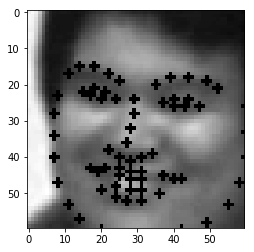

52.08646657242167 14.142135623730951 17.029386365926403 17.029386365926403 9.219544457292887 10.04987562112089 25.179356624028344
../person_data/12_139.png


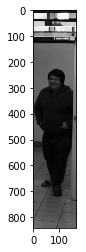

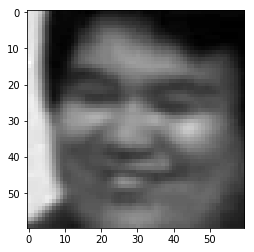

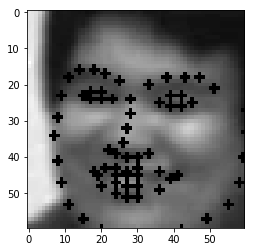

51.15662224971465 14.035668847618199 18.027756377319946 16.0312195418814 8.06225774829855 9.0 23.021728866442675
../person_data/12_14.png


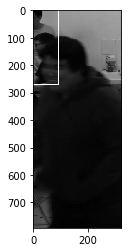

../person_data/12_140.png


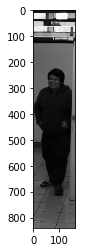

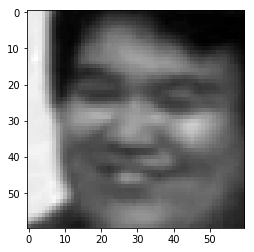

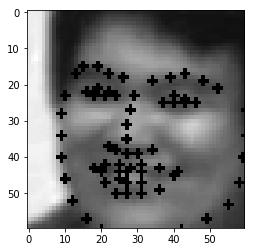

50.15974481593781 13.038404810405298 18.110770276274835 16.1245154965971 8.06225774829855 9.0 23.021728866442675
../person_data/12_141.png


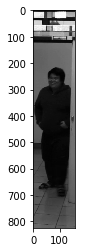

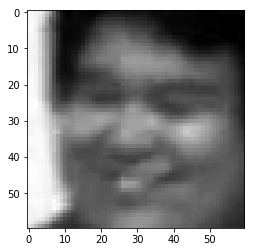

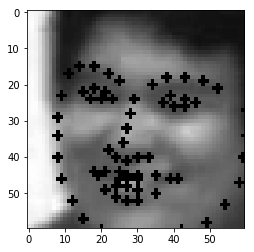

51.15662224971465 14.142135623730951 18.027756377319946 17.11724276862369 8.246211251235321 9.0 23.08679276123039
../person_data/12_142.png


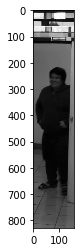

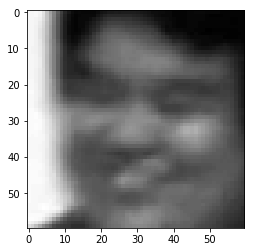

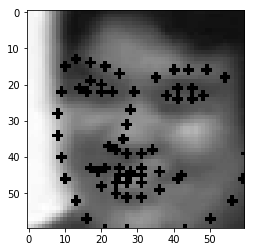

52.08646657242167 15.132745950421556 19.0 17.11724276862369 9.055385138137417 10.0 25.079872407968907
../person_data/12_143.png


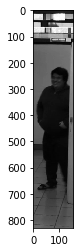

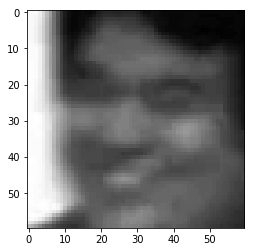

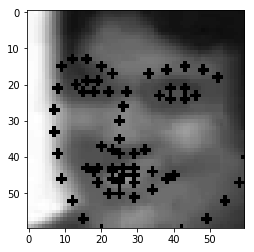

53.150729063673246 14.142135623730951 19.026297590440446 17.11724276862369 9.219544457292887 10.0 24.08318915758459
../person_data/12_144.png


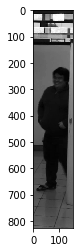

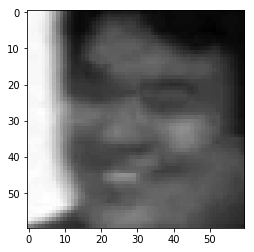

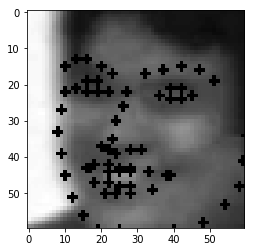

51.24451190127583 13.152946437965905 19.1049731745428 17.26267650163207 9.055385138137417 9.0 23.08679276123039


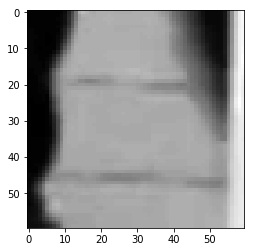

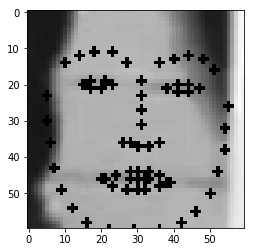

50.08991914547278 17.0 15.132745950421556 18.027756377319946 8.0 9.0 19.026297590440446
../person_data/12_145.png


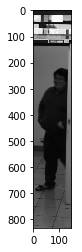

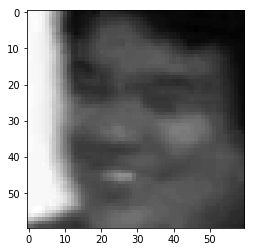

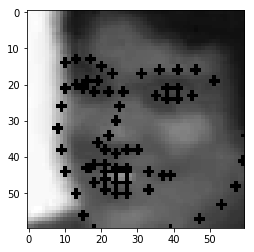

51.24451190127583 13.341664064126334 20.09975124224178 17.11724276862369 9.219544457292887 10.0 23.08679276123039
../person_data/12_146.png


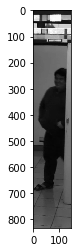

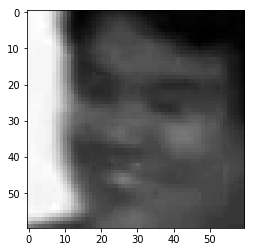

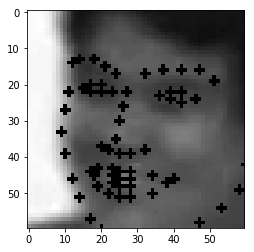

51.24451190127583 12.36931687685298 19.1049731745428 17.11724276862369 8.06225774829855 10.04987562112089 23.08679276123039
../person_data/12_147.png


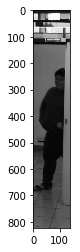

../person_data/12_148.png


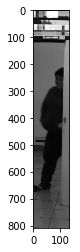

../person_data/12_149.png


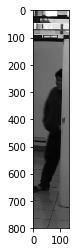

../person_data/12_15.png


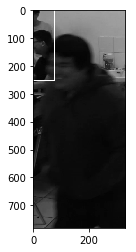

../person_data/12_150.png


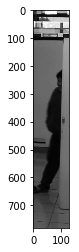

../person_data/12_151.png


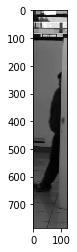

../person_data/12_152.png


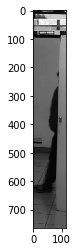

../person_data/12_16.png


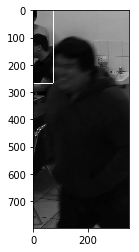

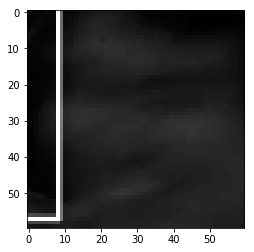

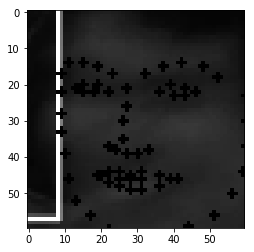

51.0098029794274 14.0 20.024984394500787 18.0 9.055385138137417 10.0 22.02271554554524
../person_data/12_17.png


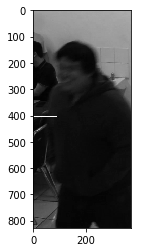

../person_data/12_18.png


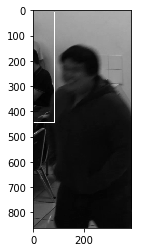

../person_data/12_19.png


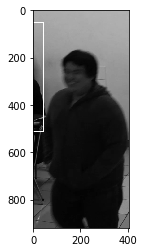

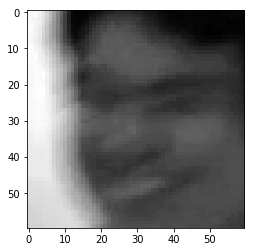

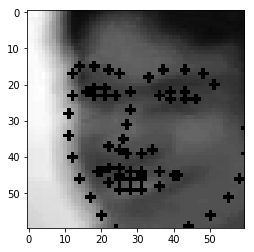

49.040799340956916 13.0 18.110770276274835 17.029386365926403 8.06225774829855 10.04987562112089 22.02271554554524
../person_data/12_2.png


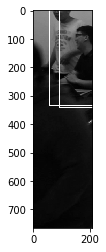

../person_data/12_20.png


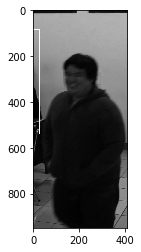

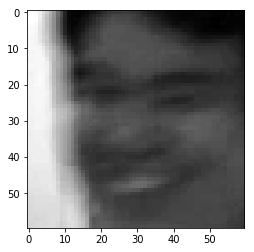

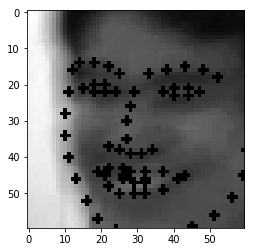

50.039984012787215 13.038404810405298 19.026297590440446 17.029386365926403 9.055385138137417 10.0 24.020824298928627
../person_data/12_21.png


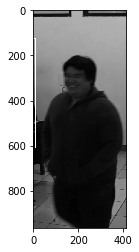

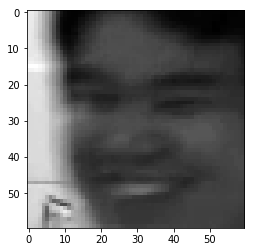

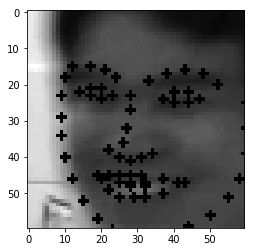

51.03920062069938 14.0 19.026297590440446 18.0 9.055385138137417 10.0 24.08318915758459
../person_data/12_22.png


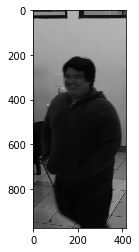

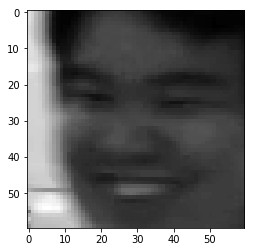

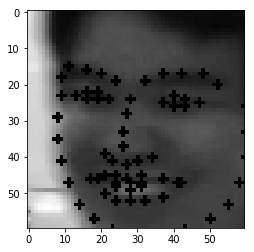

51.088159097779204 15.033296378372908 20.024984394500787 18.027756377319946 9.055385138137417 10.0 25.019992006393608
../person_data/12_23.png


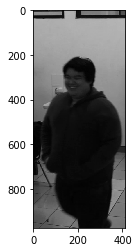

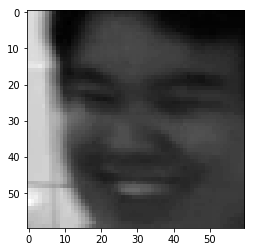

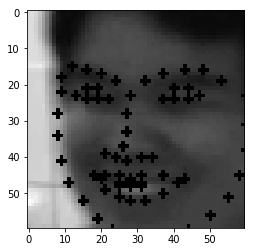

51.0098029794274 15.033296378372908 21.0 18.027756377319946 9.055385138137417 10.04987562112089 25.019992006393608
../person_data/12_24.png


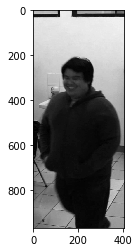

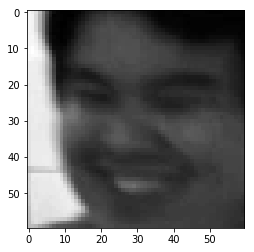

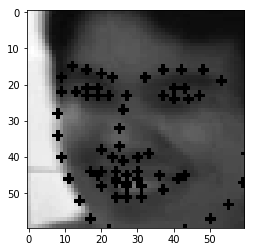

52.08646657242167 14.0 21.02379604162864 18.027756377319946 9.055385138137417 10.0 26.019223662515376
../person_data/12_25.png


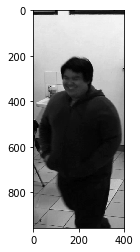

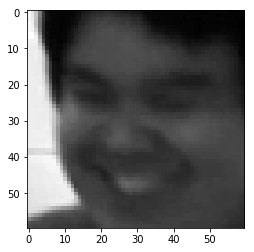

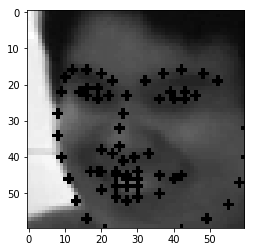

52.08646657242167 13.038404810405298 20.0 18.027756377319946 8.06225774829855 10.04987562112089 25.019992006393608
../person_data/12_26.png


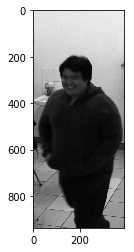

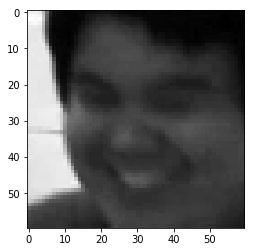

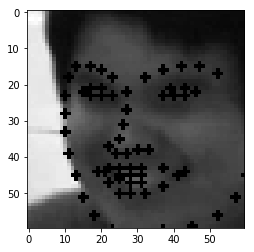

52.0 12.0 20.024984394500787 17.0 8.06225774829855 9.055385138137417 24.0
../person_data/12_27.png


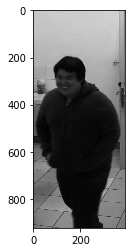

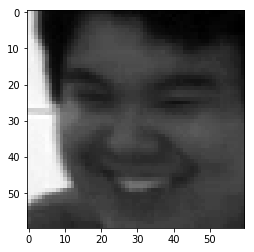

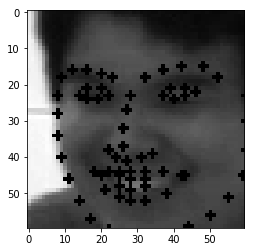

52.0 14.0 20.0 18.027756377319946 8.0 9.055385138137417 25.019992006393608
../person_data/12_28.png


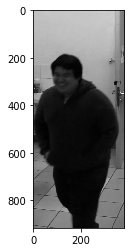

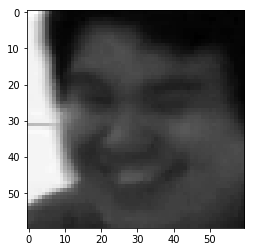

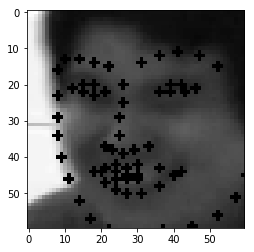

53.009433122794285 14.035668847618199 21.02379604162864 19.0 9.055385138137417 10.04987562112089 24.0
../person_data/12_29.png


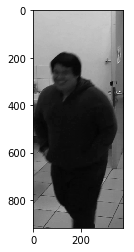

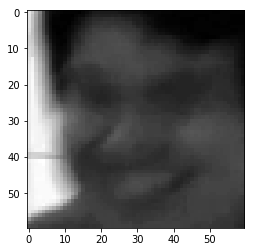

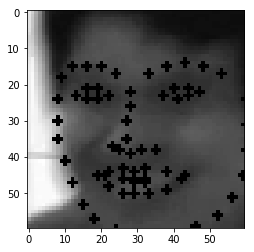

52.0 15.033296378372908 20.0 17.0 9.0 10.04987562112089 24.0
../person_data/12_3.png


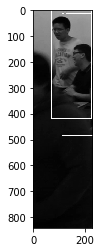

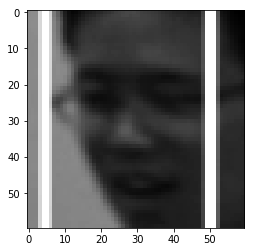

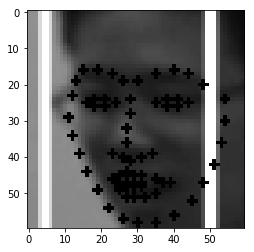

42.01190307520001 13.0 18.027756377319946 17.0 8.0 9.0 16.0312195418814
../person_data/12_30.png


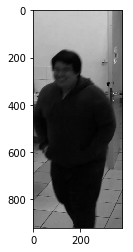

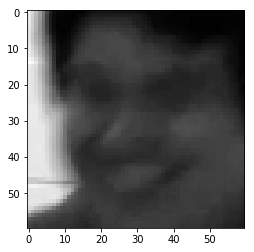

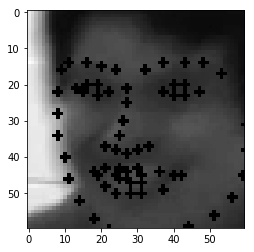

53.03772242470448 15.0 21.02379604162864 18.0 9.055385138137417 10.0 24.020824298928627
../person_data/12_31.png


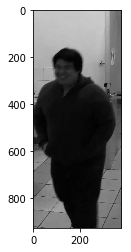

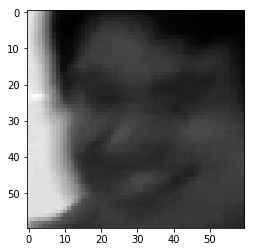

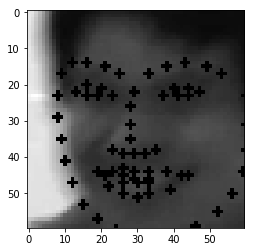

52.0 16.0 20.0 17.0 10.04987562112089 10.04987562112089 25.019992006393608
../person_data/12_32.png


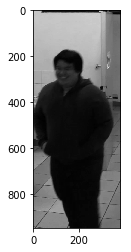

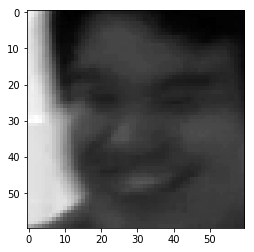

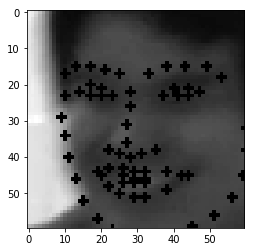

51.0098029794274 15.0 20.024984394500787 18.0 9.055385138137417 10.04987562112089 25.019992006393608
../person_data/12_33.png


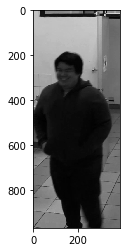

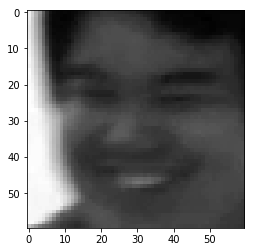

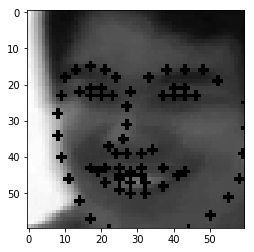

51.03920062069938 14.0 19.026297590440446 17.029386365926403 9.055385138137417 9.0 26.019223662515376
../person_data/12_34.png


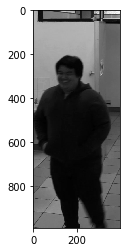

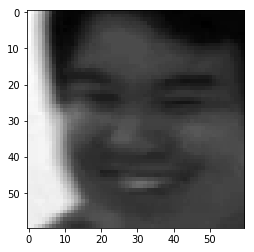

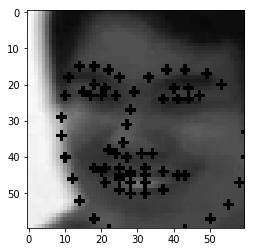

51.088159097779204 14.0 20.09975124224178 18.110770276274835 9.055385138137417 10.04987562112089 25.079872407968907
../person_data/12_35.png


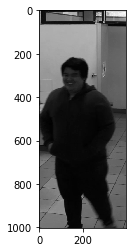

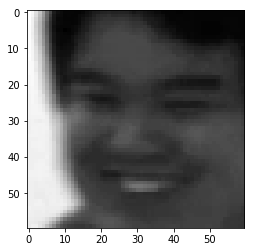

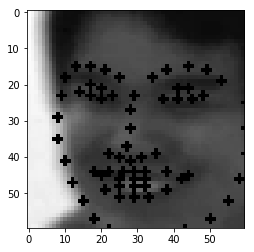

51.03920062069938 15.0 19.026297590440446 18.027756377319946 9.055385138137417 11.045361017187261 26.019223662515376
../person_data/12_36.png


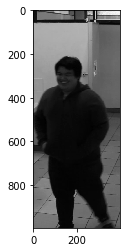

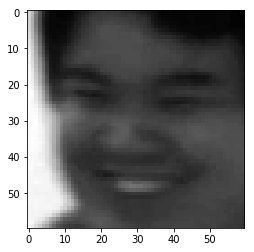

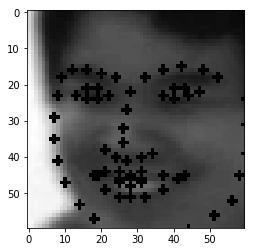

52.009614495783374 15.0 20.0 19.026297590440446 9.0 10.04987562112089 25.0
../person_data/12_37.png


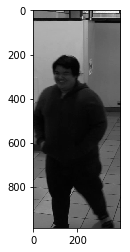

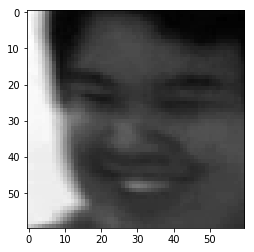

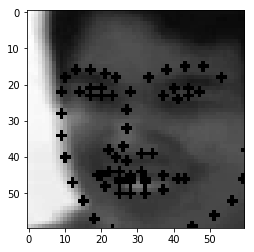

53.03772242470448 14.0 20.0 19.026297590440446 9.055385138137417 10.04987562112089 24.020824298928627
../person_data/12_38.png


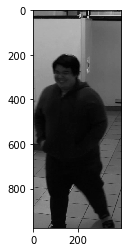

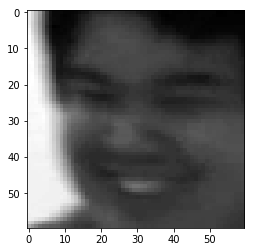

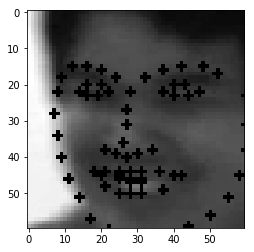

52.009614495783374 15.0 20.024984394500787 18.027756377319946 8.0 10.0 24.020824298928627
../person_data/12_39.png


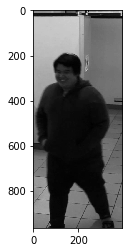

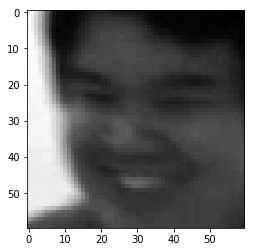

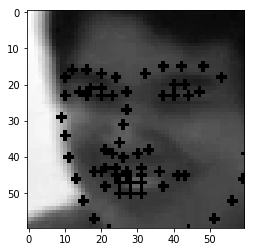

52.009614495783374 14.0 21.02379604162864 18.027756377319946 9.055385138137417 10.04987562112089 25.019992006393608
../person_data/12_4.png


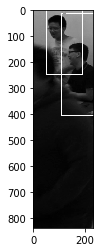

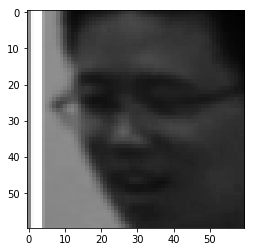

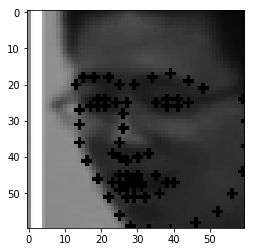

45.09988913511872 12.0 19.026297590440446 16.0 7.0710678118654755 9.0 17.0
../person_data/12_40.png


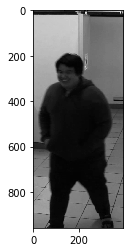

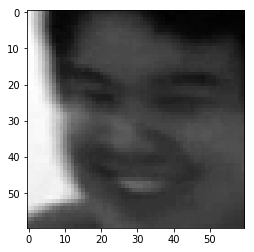

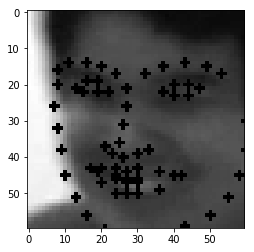

53.08483775994799 16.0312195418814 21.0 19.026297590440446 9.055385138137417 10.04987562112089 25.079872407968907


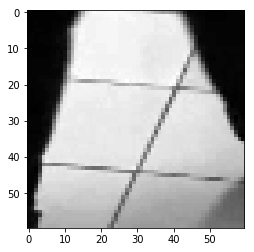

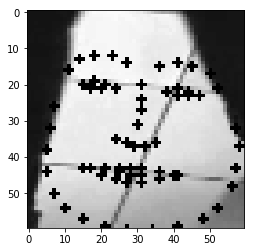

50.35871324805669 16.1245154965971 17.08800749063506 17.11724276862369 9.055385138137417 9.055385138137417 26.076809620810597
../person_data/12_41.png


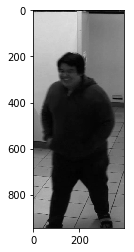

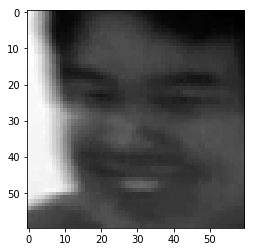

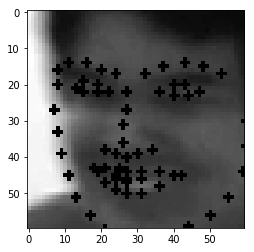

53.03772242470448 16.0312195418814 21.0 18.0 9.055385138137417 11.0 24.08318915758459
../person_data/12_42.png


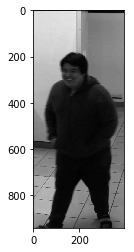

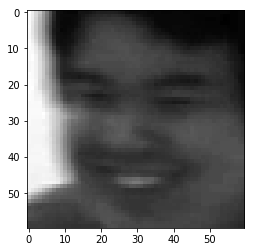

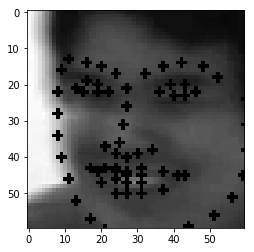

52.03844732503075 15.033296378372908 20.024984394500787 19.0 9.055385138137417 10.0 26.076809620810597
../person_data/12_43.png


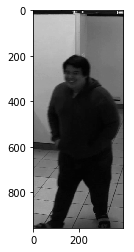

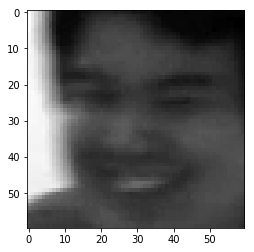

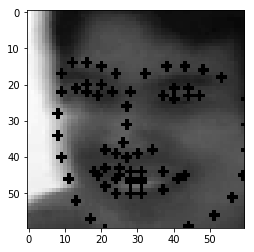

51.03920062069938 15.0 21.02379604162864 18.027756377319946 10.04987562112089 10.0 25.019992006393608
../person_data/12_44.png


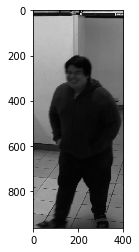

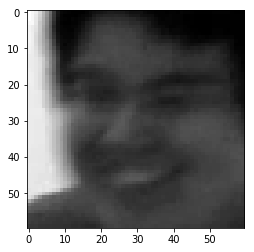

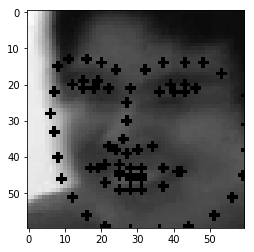

53.009433122794285 16.0312195418814 21.02379604162864 18.027756377319946 10.04987562112089 10.04987562112089 25.019992006393608
../person_data/12_45.png


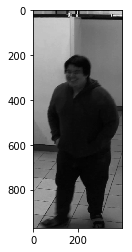

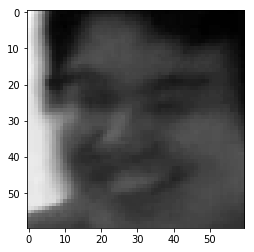

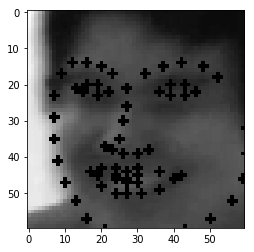

54.037024344425184 14.0 20.024984394500787 18.027756377319946 9.055385138137417 10.0 25.019992006393608
../person_data/12_46.png


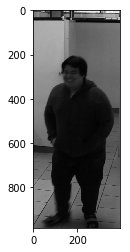

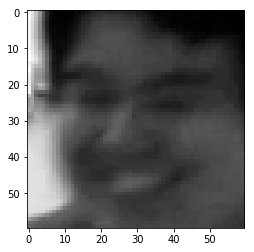

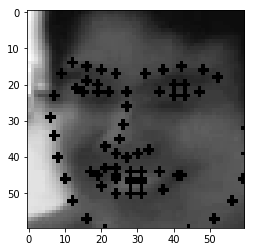

54.00925846556311 15.0 20.024984394500787 18.0 9.055385138137417 11.0 25.019992006393608
../person_data/12_47.png


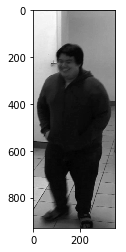

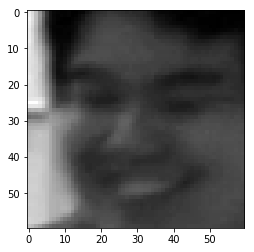

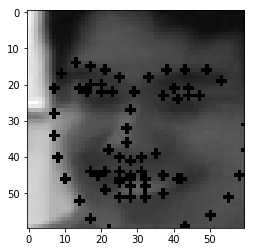

54.08326913195984 16.0312195418814 20.024984394500787 19.026297590440446 9.055385138137417 10.0 25.079872407968907
../person_data/12_48.png


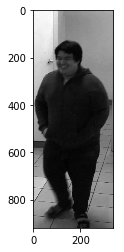

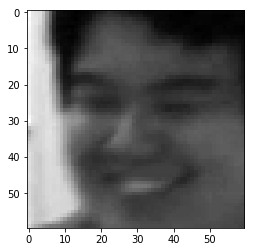

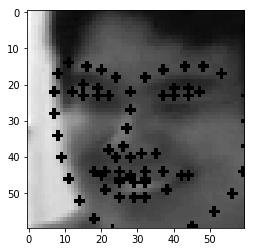

53.009433122794285 16.0312195418814 21.02379604162864 18.0 10.04987562112089 10.04987562112089 26.019223662515376
../person_data/12_49.png


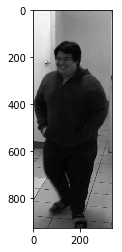

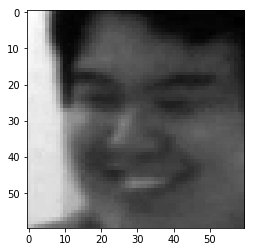

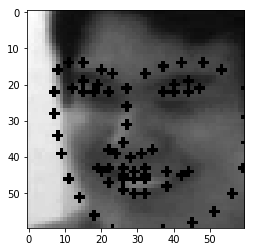

53.009433122794285 15.033296378372908 21.02379604162864 19.026297590440446 10.04987562112089 10.04987562112089 25.019992006393608
../person_data/12_5.png


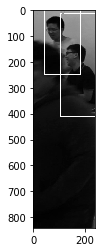

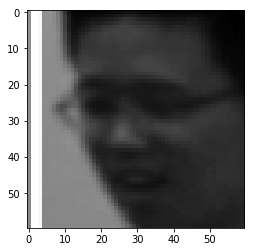

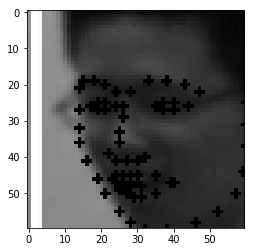

46.04345773288535 10.04987562112089 19.0 15.033296378372908 7.0 9.0 17.029386365926403
../person_data/12_50.png


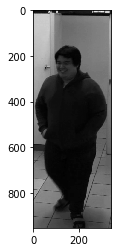

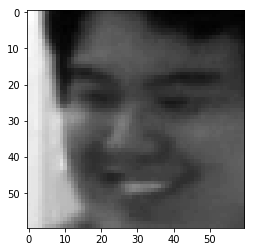

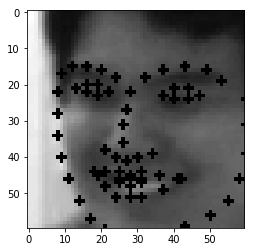

52.03844732503075 15.033296378372908 21.02379604162864 19.026297590440446 9.055385138137417 10.0 24.08318915758459
../person_data/12_51.png


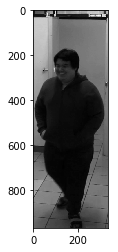

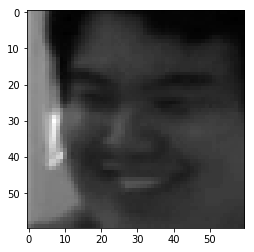

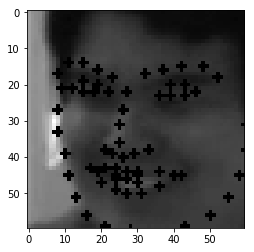

52.03844732503075 15.033296378372908 20.024984394500787 18.027756377319946 10.04987562112089 10.04987562112089 25.079872407968907
../person_data/12_52.png


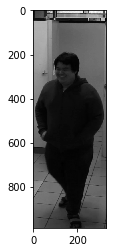

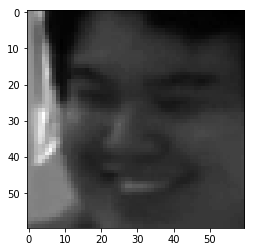

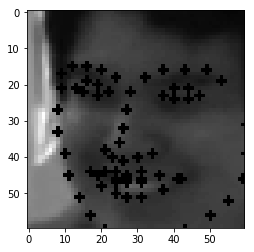

52.08646657242167 15.033296378372908 21.02379604162864 19.1049731745428 9.055385138137417 10.0 25.079872407968907
../person_data/12_53.png


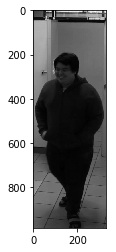

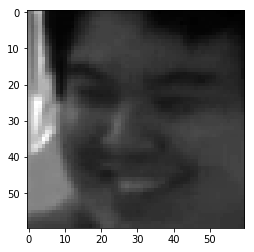

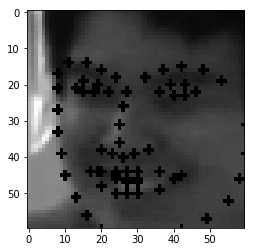

53.08483775994799 16.0312195418814 21.02379604162864 18.027756377319946 9.055385138137417 10.0 25.019992006393608
../person_data/12_54.png


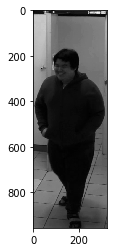

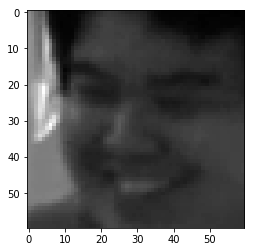

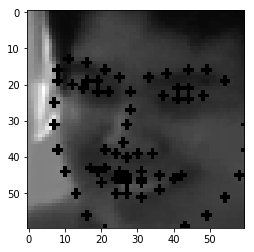

53.150729063673246 17.11724276862369 21.02379604162864 18.027756377319946 10.198039027185569 11.0 25.079872407968907
../person_data/12_55.png


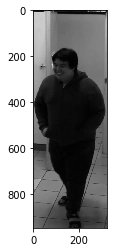

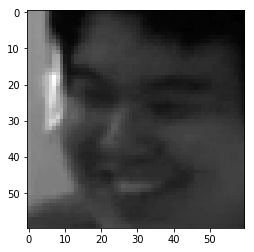

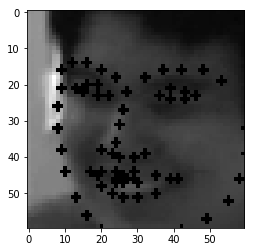

52.08646657242167 15.132745950421556 21.02379604162864 18.110770276274835 9.219544457292887 10.0 24.08318915758459
../person_data/12_56.png


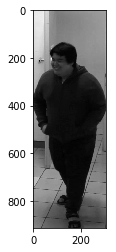

../person_data/12_57.png


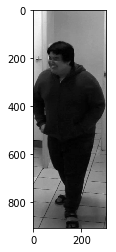

../person_data/12_58.png


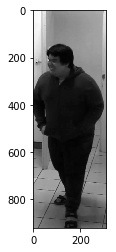

../person_data/12_59.png


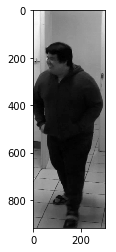

../person_data/12_6.png


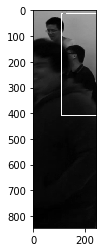

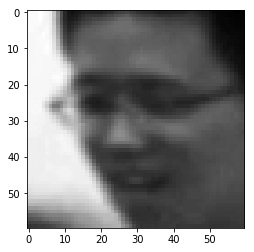

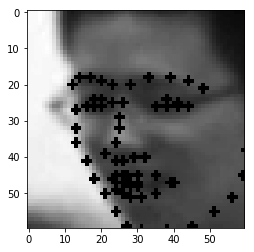

48.041648597857254 11.0 20.024984394500787 16.0 7.0710678118654755 9.0 17.029386365926403
../person_data/12_60.png


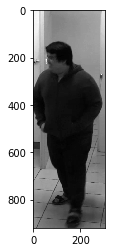

../person_data/12_61.png


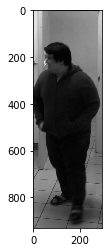

../person_data/12_62.png


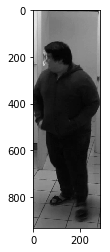

../person_data/12_63.png


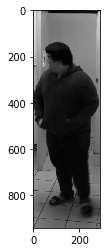

../person_data/12_64.png


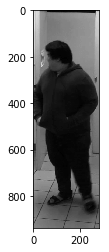

../person_data/12_65.png


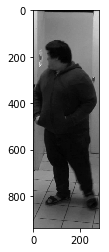

../person_data/12_66.png


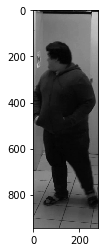

../person_data/12_67.png


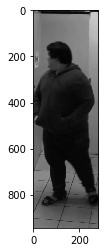

../person_data/12_68.png


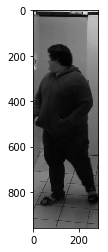

../person_data/12_69.png


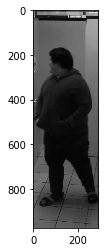

../person_data/12_7.png


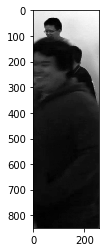

../person_data/12_70.png


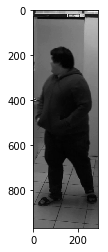

../person_data/12_71.png


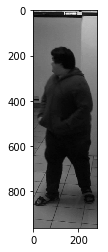

../person_data/12_72.png


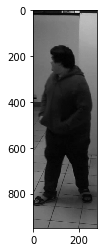

../person_data/12_73.png


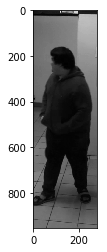

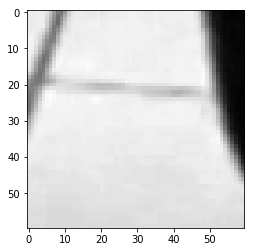

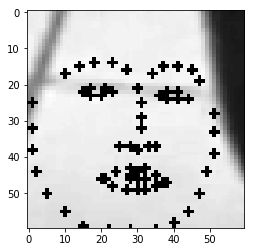

50.08991914547278 17.029386365926403 13.152946437965905 17.0 8.0 8.06225774829855 18.027756377319946
../person_data/12_74.png


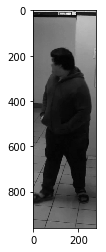

../person_data/12_75.png


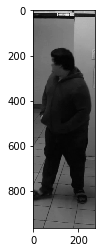

../person_data/12_76.png


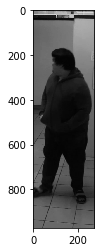

../person_data/12_77.png


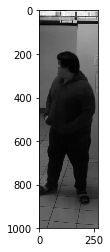

../person_data/12_78.png


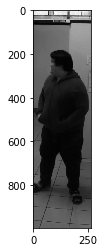

../person_data/12_79.png


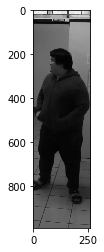

../person_data/12_8.png


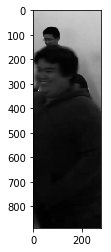

../person_data/12_80.png


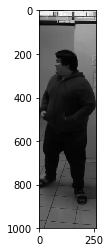

../person_data/12_81.png


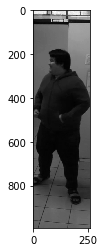

../person_data/12_82.png


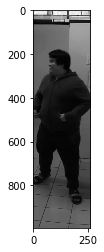

../person_data/12_83.png


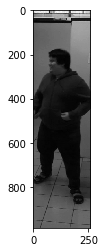

../person_data/12_84.png


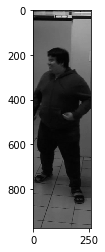

../person_data/12_85.png


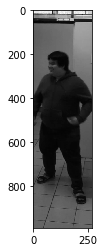

../person_data/12_86.png


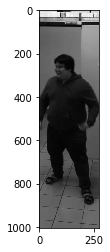

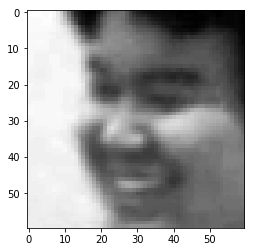

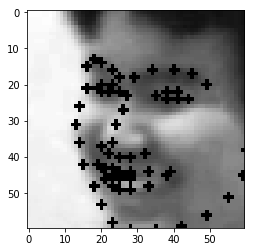

45.09988913511872 9.486832980505138 20.09975124224178 17.11724276862369 6.082762530298219 9.055385138137417 20.09975124224178
../person_data/12_87.png


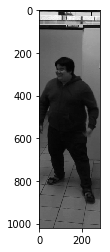

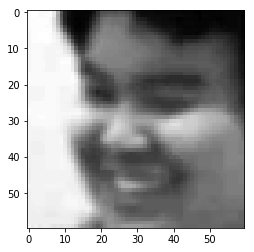

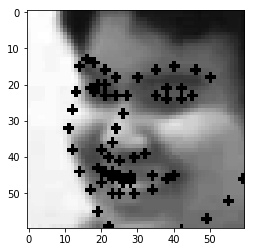

49.01020301937138 10.44030650891055 20.0 18.110770276274835 7.280109889280518 10.0 21.095023109728988
../person_data/12_88.png


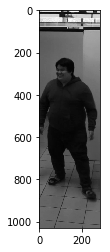

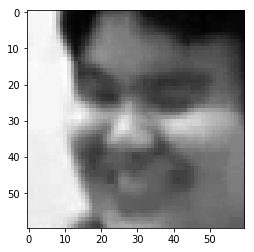

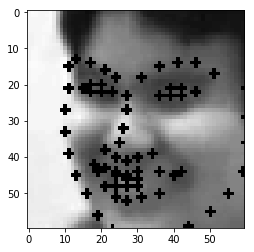

49.0 13.341664064126334 20.024984394500787 18.0 8.06225774829855 10.04987562112089 24.08318915758459
../person_data/12_89.png


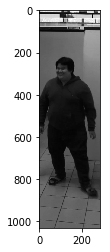

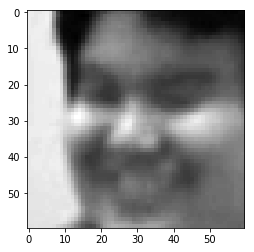

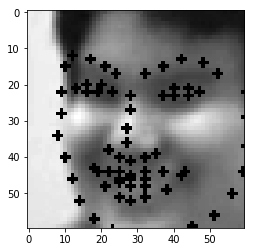

51.0 14.142135623730951 20.0 18.0 10.04987562112089 10.04987562112089 25.019992006393608
../person_data/12_9.png


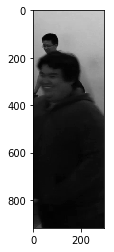

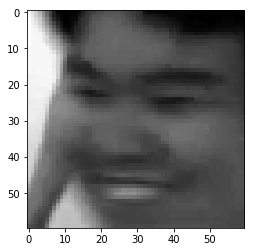

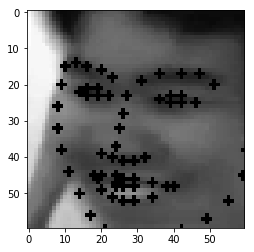

52.08646657242167 13.341664064126334 20.024984394500787 18.027756377319946 8.06225774829855 10.04987562112089 22.20360331117452
../person_data/12_90.png


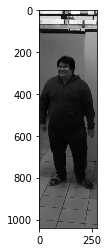

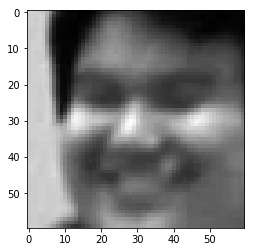

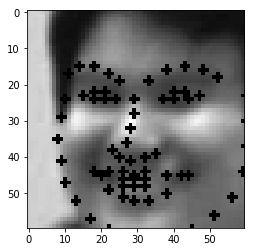

50.00999900019995 14.142135623730951 19.026297590440446 17.029386365926403 9.055385138137417 10.04987562112089 26.019223662515376
../person_data/12_91.png


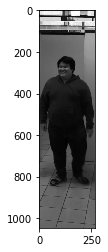

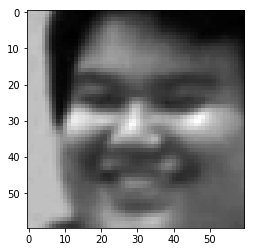

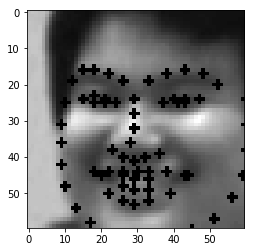

50.00999900019995 14.0 19.026297590440446 17.0 9.055385138137417 10.04987562112089 26.019223662515376
../person_data/12_92.png


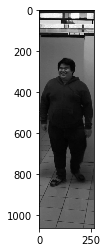

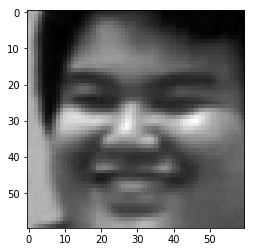

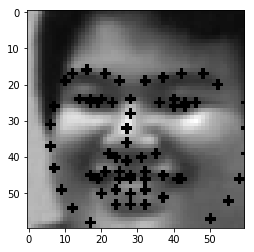

53.009433122794285 15.0 20.024984394500787 17.029386365926403 9.055385138137417 10.0 25.019992006393608
../person_data/12_93.png


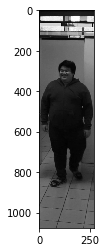

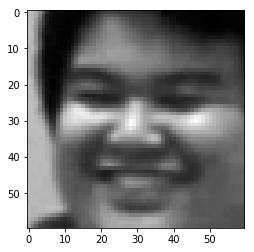

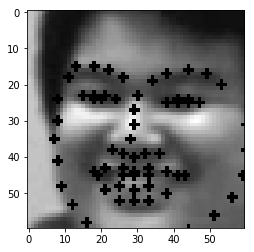

53.009433122794285 15.0 19.026297590440446 17.029386365926403 9.055385138137417 9.0 25.019992006393608
../person_data/12_94.png


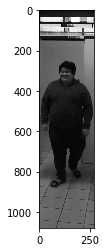

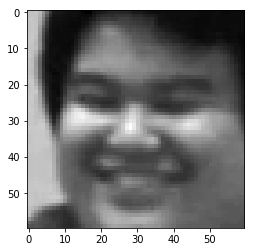

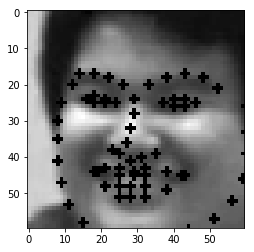

51.0098029794274 14.0 19.026297590440446 17.029386365926403 8.06225774829855 9.0 25.019992006393608
../person_data/12_95.png


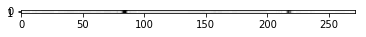

../person_data/12_96.png


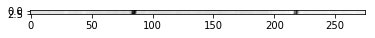

../person_data/12_97.png


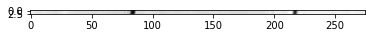

../person_data/12_98.png


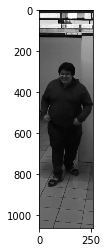

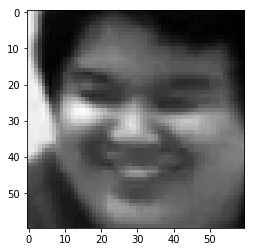

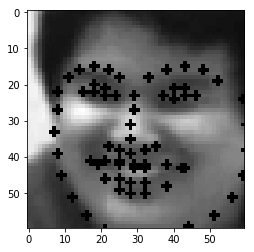

51.03920062069938 14.0 19.026297590440446 16.0312195418814 9.055385138137417 9.0 26.076809620810597
../person_data/12_99.png


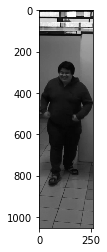

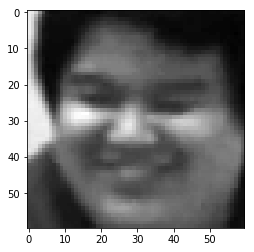

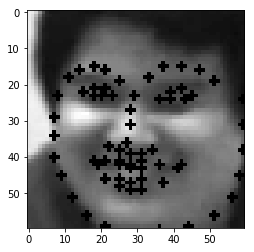

51.0098029794274 14.035668847618199 18.027756377319946 16.0312195418814 8.06225774829855 9.055385138137417 24.020824298928627


In [33]:
generate_keyframe_from_frames(input_path_list, 'hehe', haar_classifier, extractor)

# Face Dataset Creation

In [34]:
import os

In [35]:
haar_classifier = cv.CascadeClassifier('model_data/haarcascade_frontalface_alt.xml')
extractor = dlib.shape_predictor('model_data/shape_predictor_68_face_landmarks.dat')

In [36]:
person_img_dir_path = '../person_data'
person_img_path_list = os.listdir(person_img_dir_path)
person_img_path_list = sorted([os.path.join(person_img_dir_path, img_path) for img_path in person_img_path_list])

In [37]:
face_img_dir_path = '../face_data'

In [38]:
def create_face_dataset(person_id, person_img_path_list):
    counter = 0
    for idx, img_path in enumerate(person_img_path_list):
        if ('/' + str(person_id) + '_' in img_path):
            filename = img_path
            print(filename)
            person_img = cv.imread(filename)
            img_with_face_bboxes, faces_position = detect_faces(haar_classifier, person_img)
            
            if len(faces_position) != 0:
                
                x, y, w, h = faces_position[0]
                cropped_face_img = person_img[y:y+h, x:x+w]
                cv.imwrite(os.path.join('../face_data', str(person_id) + '_' + str(counter) + '.png'), cropped_face_img)
                print(counter)
                counter += 1

In [39]:
# create_face_dataset(17, person_img_path_list)